# Часть 1
## Разложение временных рядов с помощью метода SSA

В этой части рассмотрена техника **анализа сингулярного спектра (SSA)**,
метода декомпозиции временных рядов. SSA разлагает временной ряд на набор суммируемых компонентов, которые группируются вместе и интерпретируются как *тренд*, *периодичность* и *шум*. SSA отчетливо показывает **разделимость** базовых компонент и может легко выделять цикличность, возникающую в разных временных масштабах, даже в очень зашумленных данных временных рядов. Исходный временной ряд восстанавливается путем суммирования всех его компонент.

Таким образом, SSA можно использовать для анализа и реконструкции временных рядов с различными компонентами или без них по желанию. Примеры использования SSA:
* Сглаженная версия временного ряда, с использованием небольшого подмножества его компонентов;
* Поиск периодических компоненты временного ряда, чтобы понять основные процессы, которые породили временной ряд;
* Реконструировать исходный временной ряд без его периодических составляющих;
* Удаление всех трендовых и периодических компонент из ряда, оставив только "шум", который может иметь значение.

Для начала импортируем необходимые библиотеки

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from cycler import cycler
from ssa_module import plot_2d, X_to_TS, Hankelise, components_auto_group, SSA_simple_plt, SSA_plt_groups, SSA

plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2

cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

# 1. Загрузка данных <a name="Section1"></a>

In [2]:
data = pd.read_csv("data/data_gulf_of_finland.csv")
# изначально у нас 2651 записей с  2012 по 2020 год, обрезаем "лишние" (2019-2020г и сентябрь-декабрь 2012)
data = data.loc[data["NAME"] == "BELOGORKA, RS"][122:-500] # берем ежедневные данные о температуре, собранные с 1 станции в ЛО
data = data.set_index("DATE") # установим дату в качестве индекса
data.TEMP = (data.TEMP - 32) * 5/9 # преобразуем из градусов по Фаренгейту в градусы по Цельсию
data["TEMP"]

DATE
2013-01-01     1.388889
2013-01-02     0.833333
2013-01-03     0.277778
2013-01-04    -1.166667
2013-01-05    -3.166667
                ...    
2018-08-08    17.277778
2018-08-09    20.500000
2018-08-10    23.333333
2018-08-11    20.277778
2018-08-12    14.444444
Name: TEMP, Length: 2029, dtype: float64

Text(0, 0.5, 'temp')

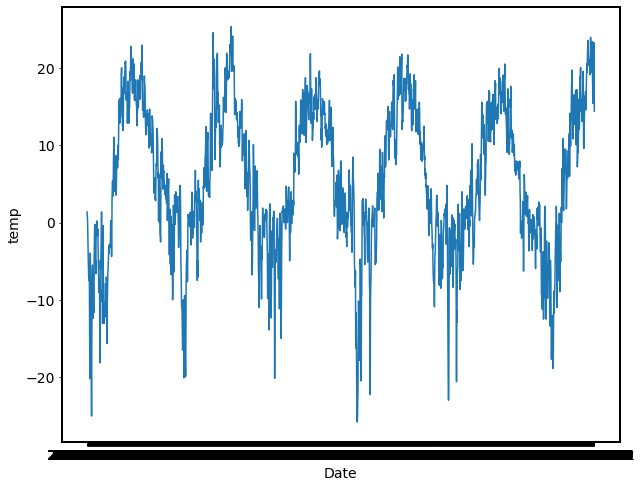

In [3]:
plt.plot(data.TEMP)
plt.xlabel("Date")
plt.ylabel("temp")

# 2. Введение в метод SSA<a name="Section2"></a>
## 2.1 Переход к траекторной матрице<a name="Section2.1"></a>
Первым шагом SSA является сопоставление временного ряда $F$ с последовательностью многомерных векторов задержек. Пусть целое число $L$ будет длиной **окна**, $2 \le L \le N/2$. Таким образом формируется окно из подпоследовательностей $\{f_i, \ f_{i+1}, \ldots , \ f_{i+L-1}\}$, для  $i=0,\ldots,N-L$.

\begin{align*}
X_0 & = (f_0, \ f_1, \ f_2,  \ldots, \ f_{L-1} )^{\text{T}} \\
X_1 & = (f_1, \ f_2, \ f_3,  \ldots, \ f_L )^{\text{T}} \\
X_2 & = (f_2, \ f_3, \ f_4,  \ldots, \ f_{L+1} )^{\text{T}} \\
X_3 & = (f_3, \ f_4, \ f_5,  \ldots, \ f_{L+2} )^{\text{T}} \\
& \quad \quad \quad  \vdots \\
X_{N-L} & = (f_{N-L}, \ f_{N-L+1}, \ f_{N-L+2}, \ \ldots, \ f_{N-1} )^{\text{T}}.
\end{align*}

Эти вектора образуют $L$-*траекторной матрицы*, $\mathbf{X}$, временного ряда:

$$\mathbf{X} = \begin{bmatrix}
f_0 & f_1 & f_2 & f_3 &\ldots & f_{N-L} \\
f_1 & f_2 & f_3 & f_4 &\ldots & f_{N-L+1} \\
f_2 & f_3 & f_4 & f_5 &\ldots & f_{N-L+2} \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
f_{L-1} & f_{L} & f_{L+1} & f_{L+2} & \ldots & f_{N-1} \\
\end{bmatrix}$$

Из приведенной выше матрицы видно, что элементы *антидиагоналей* (то есть диагоналей, идущих снизу слева направо) равны. Этот тип матрицы известен как ***Ганкелева*** матрица.

$K = N - L + 1$ представляют количество столбцов в матрице траекторий. **Мы будем называть столбцы $\mathbf{X}$ векторами задержек $L$, а строки-векторами задержек $K$.**

In [4]:
F = data.TEMP.values
N = len(F)
L = round(N * 0.3) # Длина окна - 30% от длины ряда
print(N, L) # в нашем случае - это приблизительно 2 года, сами данные (ежедневные) за ~5.5 лет
K = N - L + 1 # Число колонок в траекторной матрице
# Создаем траекторную матрицу, вытянув соответствующие подпоследовательности из F и сложив их в виде столбцов.
X = np.column_stack([F[i:i+L] for i in range(0,K)])
# Примечание: i+L выше дает нам до i+L-1, так как верхние границы массива numpy не включаются.

2029 609


Text(0.5, 1.05, 'Траекторная матрица')

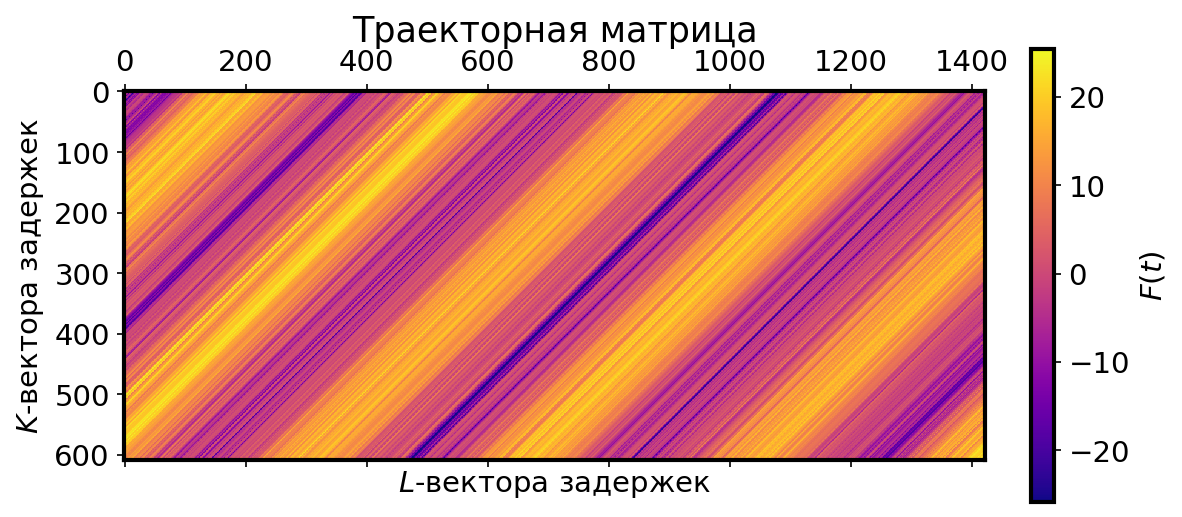

In [5]:
fig, ax = plt.subplots(figsize=(8,4), dpi=150)
ax = ax.matshow(X)
plt.xlabel("$L$-вектора задержек")
plt.ylabel("$K$-вектора задержек")
fig.colorbar(ax, fraction=0.025)
ax.colorbar.set_label("$F(t)$")
plt.title("Траекторная матрица", pad=15)

Исходя из визуализации траекторной матрицы мы видим, что:
1. Элементы на антидиагоналях равны
2. Значения чередуются с определенным шагом

## 2.2 Разложение траекторной матрицы<a name="Section2.2"></a>
На этом шаге мы разложим нашу траекторную матрицу с помощью SVD (Singular value decomposition или Сингулярное разложение).
Разложение матрицы — это представление матрицы в виде произведения матриц,
обладающих некоторыми определёнными свойствами (например, ортогональностью, симметричностью, диагональностью).

Сингулярным разложением матрицы Х является разложение следующего вида -

$$\mathbf{X} = \mathbf{U\Sigma V}^{\text{T}}$$
где:
* $\mathbf{U}$ размера $L \times L$ ортонормированная матрица ***левых сингулярных векторов*** of $\mathbf{X}$;
* $\mathbf{\Sigma}$ размера $L \times K$ прямоугольная диагональная матрица $L$ ***сингулярных значений*** of $\mathbf{X}$, упорядоченных от большего к меньшему;
* $\mathbf{V}$ размера $K \times K$ ортонормированная матрица ***правых сингулярных векторов*** of $\mathbf{X}$.

Теперь рассмотрим каждую из них подробнее.

### 2.2.1 $\mathbf{U}$ матрица<a name="Section2.2.1"></a>
$\mathbf{U}$ размера $L \times L$ это матрица с ортонормированными колонками
$$
    U_i \cdot U_j = \left\{
  \begin{array}{lr}
    1 \ & i = j \\
    0 \ & i \ne j
  \end{array}
\right.
$$
$\mathbf{UU}^{\text{T}} = \mathbf{U}^{\text{T}}\mathbf{U} = \mathbf{1}$.

$Z_i = \sigma_i V_i$ это вектор столбец, такой что
$$\mathbf{X} = \sum_{i=0}^{d-1} U_i Z_i^{\text{T}}$$
и каждый вектор-столбец с $L$-задержкой, $X_j$
$$X_j = \sum_{i=0}^{d-1}z_{j,i}U_i$$
$z_{j,i}$ это $j$-ый компонент вектора $Z_i$. Выражение для $X_j$ предполагает что $\mathcal{U} = \{U_0,
 \ldots, U_{d-1} \}$ это базис который образует пространство векторов-колонок для нашей траекторной матрицы, а $z_{j,i}$ это $i$-ый коэфициент $X_j$ представленного в базисе $\mathcal{U}$. **Колонки матрицы $\mathbf{U}$ образуют ортонормированный базис который описывает временные подпоследовательности $\left\{ f_i, \ldots, f_{i+L-1}\right\}_{i=0}^{N-L}$ внутри столбцов траекторной матрицы.**

### 2.2.2 $\mathbf{V}$ матрица<a name="Section2.2.2"></a>
Матрица $\mathbf{V}$ для SVD $\mathbf{X}$—это матрица $K \times K$ с ортонормированными столбцами, которая, как и матрица $\mathbf{U}$ унитарная.
Чтобы интерпретировать столбцы $\mathbf{V}$ отметим, что для любых матриц соответствующей формы $\mathbf{A}$ и $\mathbf{B}$, $\left(\mathbf{AB}\right)^{\text{T}} = \mathbf{B}^{\text{T}}\mathbf{A}^{\text{T}}$. Принимая транспонирование $\mathbf{X}$, мы, следовательно, имеем
\begin{align*}
\mathbf{X}^{\text{T}} & = \mathbf{V \Sigma}^{\text{T}}\mathbf{U}^{\text{T}} \\
& = \sum_{i=0}^{d-1}V_i Y_i^{\text{T}}
\end{align*}
где мы установили $Y_i = \sigma_i U_i$. Тогда
$$X^{(\text{T})}_j = \sum {i=0}^{d-1}y_{j,i}V_i$$
где $X^{(\text{T})}_j$ - это $j$ - й столбец $\mathbf{X}^{\text{T}}$, а $y_{j,i}$ - это $j$ - й компонент вектора $Y_i$. Это выражение предполагает, что $\mathcal{V} = \{V_0, \ldots, V_{d-1}\}$ является базисом, образующим пространство столбцов $\mathbf{X}^{\text{T}}$, а $y_{j,i}$ - это коэффициент $i$-ого вектора-задержек $X^{(\text{T})}_j$, представленный в $\mathcal{V}$. Эквивалентно, $\mathcal{V}$ является базисом, который образует *пространство строк* $\mathbf{X}$. **То есть столбцы матрицы $\mathbf{V}$ образуют ортонормированный базисный набор, описывающий временные подпоследовательности $\{ f_i, \ldots, f_{i+N-L}\}_{i=0}^{L-1}$ в строках траекторной матрицы.**


### 2.2.3 $\mathbf{\Sigma}$ матрица<a name="Section2.2.3"></a>
Матрица $\mathbf{\Sigma}$ представляет собой прямоугольную диагональную матрицу $L \times K$, содержащую **сингулярные значения** $\mathbf{X}$. Сингулярные значения упорядочены от наибольшего к наименьшему, т. е. $\sigma_0 \ge \sigma_1 \ge \ldots \ge \sigma_{L-1} \ge 0$. **Мы можем интерпретировать $\sigma_i$ как коэффициент масштабирования, который определяет относительную важность собственного элемента $(U_i, \sigma_i, V_i)$ в $\mathbf{X} = \sum_{i=0}^{d-1}\sigma_i U_i V_i^{\text{T}}$.**

*Норма Фробениуса* $\mathbf{X}$, $\lvert\lvert \mathbf{X} \rvert\rvert_{\text{F}}$, задается
$$\lvert\lvert \mathbf{X} \rvert\rvert_{\text{F}} = \sqrt{\sum {j=0}^{L-1}\text{k=0}^{K-1} \lvert x_{j,k}\rvert^2}$$
где $x_{j,k}$ обозначает элемент в $j$ - й строке и $k$ - м столбце $\mathbf{X}$.

Давайте обратим внимание на элементарные матрицы $\mathbf{X}_i = \sigma_i U_i V_i^{\text{T}}$. Теперь для векторного произведения, такого как $U_i V_i^{\text{T}}$, у нас есть $\lvert \lvert U_i V_i^{\text{T}} \rvert \rvert_{\text{F}} = \lvert \lvert U_i \rvert \rvert_{\text{F}}$, который просто равен 1 из-за нормализации $U_i$ и $V_i$. Из этого результата становится ясно, что $\lvert\lvert \mathbf{X}_i \rvert\rvert_{\text{F}} = \sigma_i$. Также оказывается, что
$$\lvert\lvert \mathbf{X} \rvert\rvert_{\text{F}}^2 = \sum_{i=0}^{d-1} \sigma_i^2$$
т. е. **квадратная норма Фробениуса матрицы траекторий равна сумме квадратов сингулярных значений. Это говорит о том, что мы можем принять соотношение $\sigma_i^2 / \lvert\lvert \mathbf{X} \rvert\rvert_{\text{F}}^2$ в качестве меры вклада, который элементарная матрица $\mathbf{X}_i$ вносит в расширение матрицы траекторий.**

Далее, если мы правильно умножим исходный SVD $\mathbf{X}$ на $\mathbf{X}^{\text{T}}$:
\begin{align*}
\mathbf{XX}^{\text{T}} & = \mathbf{U\Sigma V}^{\text{T}}\mathbf{X}^{\text{T}} \\
& = \mathbf{U\Sigma V}^{\text{T}} \mathbf{V \Sigma}^{\text{T}}\mathbf{U}^{\text{T}} \\
& = \mathbf{U\Sigma} \mathbf{\Sigma}^{\text{T}}\mathbf{U}^{\text{T}}
\end{align*}
Пусть квадратная диагональная матрица $\mathbf{\Sigma}^2 = \mathbf{\Sigma \Sigma}^{\text{T}}$ и умножение справа на $\mathbf{U}$ дает
$$(\mathbf{XX}^{\text{T}})\mathbf{U} = \mathbf{U}\mathbf{\Sigma}^2$$
что—учитывая, что $\mathbf{\Sigma}^2$ является диагональной матрицей с элементами $\sigma_i^2$—демонстрирует, что столбцы $\mathbf{U}$ являются собственными векторами матрицы $\mathbf{XX}^{\text{T}}$, с собственными значениями $\{\sigma_0^2, \ldots , \sigma_{L-1}^2\}$. Следуя аналогичному аргументу, умножение $\mathbf{X}$ слева на $\mathbf{X}^{\text{T}}$ показывает, что столбцы $\mathbf{V}$ являются собственными векторами матрицы $\mathbf{X}^{\text{T}}\mathbf{X}$, также с собственными значениями $\{\sigma_0^2, \ldots , \sigma_{L-1}^2\}$.


### 2.2.4 Ранг траекторной матрицы<a name="Section2.2.4"></a>
Это пространство будет не более $L$-мерным; однако, если столбцы в $\mathbf{X}$ линейно зависимы, то пространство траекторий будет $d < L$. Это проявляется в виде одного или нескольких нулевых сингулярных значений в $\mathbf{\Sigma}$. **Ранг $\mathbf{X}$ - это максимальное значение $i$, такое что $\sigma_i > 0$. Иными словами, $d = \text{ранг}\{\mathbf{X}\}$ можно рассматривать как инструментальную размерность пространства траекторий временных рядов.**

(Примечание: для зашумленных данных временных рядов пространство траекторий, вероятно, будет иметь размеры $d = L$.)

Важно отметить, что каждая элементарная матрица $\mathbf{X}_i$ имеет ранг 1, и что матрица
$$\mathbf{X}^{(r)} = \sum_{i=0}^{r} \mathbf{X}_i$$
для $r < d$ является наилучшим приближением ранга-$r$ к матрице траекторий $\mathbf{X}$, таким образом, чтобы $\lvert\lvert \mathbf{X} - \mathbf{X}^{(r)}\rvert\rvert_F$ было сведено к минимуму. **То есть мы можем суммировать первые элементарные матрицы $r$, чтобы получить оптимальное приближение с меньшей размерностью $\mathbf{X}$**.

### 2.2.5 Итог<a name="Section2.2.5"></a>
Итак, вкратце что мы сделали: перевели временной ряд $F = \{f_0, \ldots, f_{N-1}\}$ в набор векторов-столбцов, $X_i = (f_i, f_{i+1}, \ldots, f_{i+L-1})^{\text{T}}, i = 0, \ldots, N-L$, которые образуют траекторную матрицу $\mathbf{X}$. Потом разложили через SVD; нашли два ортонормированных базиса, $\mathcal{U}$ and $\mathcal{V}$, которые образуют пространство строк и колонок траекторной матрицы.
\begin{align*}
    \mathbf{X} & = \sum_{i=0}^{d-1}\sigma_i U_i V_i^{\text{T}} \\
               & \equiv \sum_{i=0}^{d-1}\mathbf{X}_i
\end{align*}
$i$-ое сингулярное значение $\sigma_i$, определяет относительный вклад $\mathbf{X}_i$ в $\mathbf{X}$. Число $d \le L$ может быть выбрано для получение аппроксимации пониженной размерности $\mathbf{X}$ сумммируя только первые $r < d$ элементарных матриц.

Многое из того, что мы рассмотрели до сих пор, является общим для SVD *любой* матрицы, а не только траекторной матрицы временного ряда. Сфокусируемся на восстановлении компонентов временного ряда по его элементарным матрицам.

In [6]:
d = np.linalg.matrix_rank(X)

U, Sigma, V = np.linalg.svd(X)
V = V.T

# Вычислим элементарные матрицы X, сохранив их в многомерном массиве NumPy.
# Для этого требуется вычислить sigma_i * U_i * (V_i)^T для каждого i
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

# Быстрая проверка: сумма всех элементарных матриц в X_elm должна быть равна X,
# с точностью до определенного порога:
if not np.allclose(X, X_elem.sum(axis=0), atol=1e-10):
    print("WARNING: The sum of X's elementary matrices is not equal to X!")

Рассмотрим первые 12 элементарных матриц

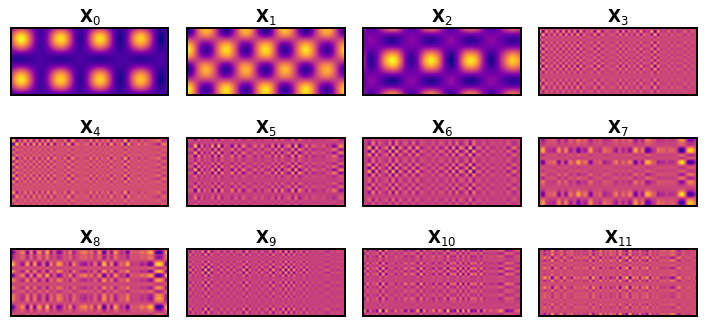

In [7]:
n = min(12, d)
for i in range(n):
    plt.subplot(5,4,i+1)
    title = "$\mathbf{X}_{" + str(i) + "}$"
    plot_2d(X_elem[i], title)
plt.tight_layout()

Здесь мы видим тренд на х0 матрице, и, скорее всего, х1 тоже принадлежит тренду, т.к. имеет схожие паттерны
начиная от х5 идут шумы, х3 и х4 - периодические компоненты, а х2 визуально кажется более близкой к тренду,
 так или иначе, ожидается, что х1, х0 и х3, х4 будут объединены (автогруппировкой)

Рассмотрим индивидуальный вклад каждой элементарной матрицы, $\dfrac{\sigma_i^2}{\sum_{k=0}^{d-1} \sigma_k^2}$, и совокупный вклад, $\dfrac{\sum_{j=0}^i \sigma_j^2}{\sum_{k=0}^{d-1} \sigma_k^2}$, из первых 12 элементарных матриц в траекторную матрицу временного ряда:

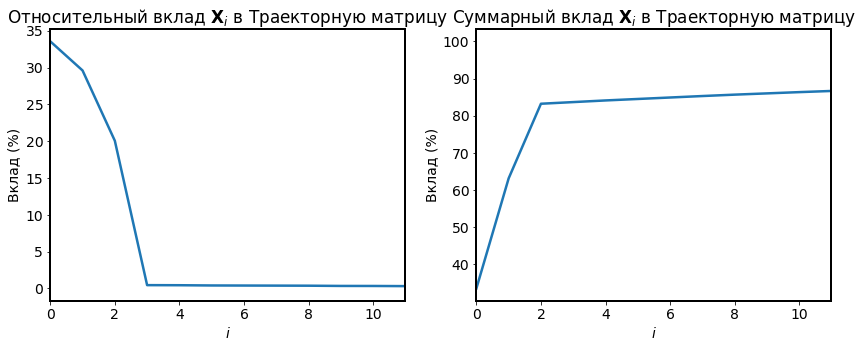

In [8]:
sigma_sumsq = (Sigma**2).sum()
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].plot(Sigma**2 / sigma_sumsq * 100, lw=2.5)
ax[0].set_xlim(0,11)
ax[0].set_title("Относительный вклад $\mathbf{X}_i$ в Траекторную матрицу")
ax[0].set_xlabel("$i$")
ax[0].set_ylabel("Вклад (%)")
ax[1].plot((Sigma**2).cumsum() / sigma_sumsq * 100, lw=2.5)
ax[1].set_xlim(0,11)
ax[1].set_title("Суммарный вклад $\mathbf{X}_i$ в Траекторную матрицу")
ax[1].set_xlabel("$i$")
ax[1].set_ylabel("Вклад (%)");

 х0 и х1 суммарно вносят около 60% в траекторную матрицу, х2 вносит ~ 25%.
 В совокупности первые три элементарных матриц составляют ~85%.
Визуально видно, что первые две матрицы вносят примерно равный вклад и их можно обьединить.
Начиная с x3 вклад становится менее 5% и мы не видим существенных изменений,
 следовательно, оставшиеся компоненты можно убрать из ряда.

## 2.Восстановление исходного ряда<a name="Section2.3"></a>
До сих пор мы сопоставляли временной ряд $F$ с рядом векторов с запаздыванием $L$, формируя матрицу траекторий$ F$. Затем мы разложили эту матрицу с помощью сингулярного разложения и построили набор *элементарных матриц*, которые составляют матрицу траекторий. Затем мы дали небольшое объяснение, размахивая руками, чтобы классифицировать эти элементарные матрицы как *тренд*, *периодичность* и *шум*.

В идеальном мире все компоненты временного ряда $F = \sum_j F^{(j)}$ были бы разделимыми, и мы бы сгруппировали полученные элементарные матрицы $\mathbf{X}_i$ соответствующим образом, так что
\begin{align*}
\mathbf{X} & = \sum_{k \in \mathcal{S}}\mathbf{X}_k + \sum_{l \in \mathcal{T}}\mathbf{X}_l + \ldots \\
& = \sum_j \mathbf{X}^{(j)}
\end{align*}
где $\mathcal{S}$ и $\mathcal{T}$-непересекающиеся наборы индексов, а $\mathbf{X}^{(j)}$ - траекторная матрица компонента временного ряда $F^{(j)}$. В этом случае каждый $\mathbf{X}^{(j)}$ будет иметь Ганкелеву структуру и построение каждого $F^{(j)}$ будет простым. Однако в этом несовершенном реальном мире ни одна траекторная матрица компонентов не будет иметь равных значений на своих антидиагоналях. Поэтому мы ищем процесс преобразования элементарной матрицы в матрицу Ханкеля, а затем во временной ряд.

Чтобы извлечь временной ряд из элементарных матриц, мы будем использовать ***диагональное усреднение***, которое определяет значения восстановленного временного ряда $\tilde{F}^{(j)}$ как средние значения соответствующих антидиагоналей матриц $\mathbf{X}^{(j)}$. Формально это выполняется с помощью оператора Ганкеля. $\hat{\mathcal{H}}$, который действует на матрицу $L \times K$  $\mathbf{X}^{(j)}$ и переводит ее в Ганкелеву матрицу $\mathbf{\tilde{X}}^{(j)}$; такую что,
$$\mathbf{\tilde{X}}^{(j)} = \hat{\mathcal{H}}\mathbf{X}^{(j)}$$
Элемент $\tilde{x}_{m,n}$ in $\mathbf{\tilde{X}}^{(j)}$, для $s = m+n$
$$
\tilde{x}_{m,n} = \left\{
  \begin{array}{lr}
    \frac{1}{s+1}\sum_{l=0}^{s} x_{l, s-l} & \ 0 \le s \le L-1 \\
    \frac{1}{L-1}\sum_{l=0}^{L-1} x_{l, s-l} & \ L \le s \le K-1 \\
    \frac{1}{K+L-s-1}\sum_{l=s-K+1}^{L} x_{l, s-l} & \ K \le s \le K+L-2 \\
  \end{array}
\right.
$$

Это вычисляет заданную $\tilde{x}_{m,n}$ путем усреднения остальных элементов антидиагонали,
к которой принадлежит $\tilde{x}_{m, n}$. Количество антидиагональных элементов для суммирования зависит
 от расположения $m$ и $n$ в матрице. На практике нам не нужна полная матрица Ханкеля
 $\mathbf{\tilde{X}}^{(j)}$, и мы можем сразу перейти к построению временного ряда $\tilde{F}^{(j)}$.

Важно отметить, что $\hat{\mathcal{H}}$ является линейным оператором, т. е. $\hat{\mathcal{H}}(\mathbf{A} + \mathbf{B}) = \hat{\mathcal{H}}\mathbf{A} + \hat{\mathcal{H}}\mathbf{B}$. Затем для матрицы траекторий $\mathbf{X}$,
\begin{align*}
\hat{\mathcal{H}}\mathbf{X} & = \hat{\mathcal{H}} \left( \sum {i=0}^{d-1} \mathbf{X}_i \right) \\
& = \sum_{i=0}^{d-1} \hat{\mathcal{H}} \mathbf{X}_i \\
& \equiv \sum_{i=0}^{d-1} \tilde{\mathbf{X}_i}
\end{align*}
Поскольку $\mathbf{X}$ уже является матрицей Ханкеля, то по определению $\hat{\mathcal{H}}\mathbf{X} = \mathbf{X}$. Следовательно, матрица траекторий может быть выражена в терминах ее элементарных матриц Ханкеля:
$$\mathbf{X} = \sum_{i=0}^{d-1} \tilde{\mathbf{X}_i}$$
Поскольку временной ряд однозначно определяется из матрицы Ханкеля, приведенное выше выражение также определяет временной ряд $F$ как сумму его компонентов $\tilde{F}_i$. Мы должны сгруппировать эти компоненты вместе и классифицировать их.

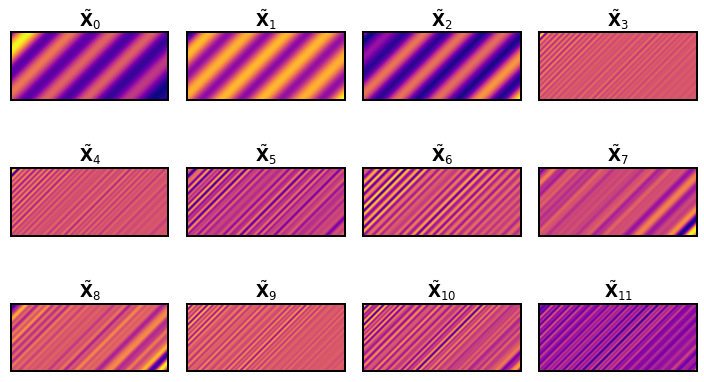

In [9]:
n = min(d, 12)
for j in range(0,n):
    plt.subplot(4,4,j+1)
    title = r"$\tilde{\mathbf{X}}_{" + str(j) + "}$"
    plot_2d(Hankelise(X_elem[j]), title)
plt.tight_layout()

Здесь мы также видим, что начиная с х5 идут шумы, х0-х4 визуально больше напоминают периодические компоненты

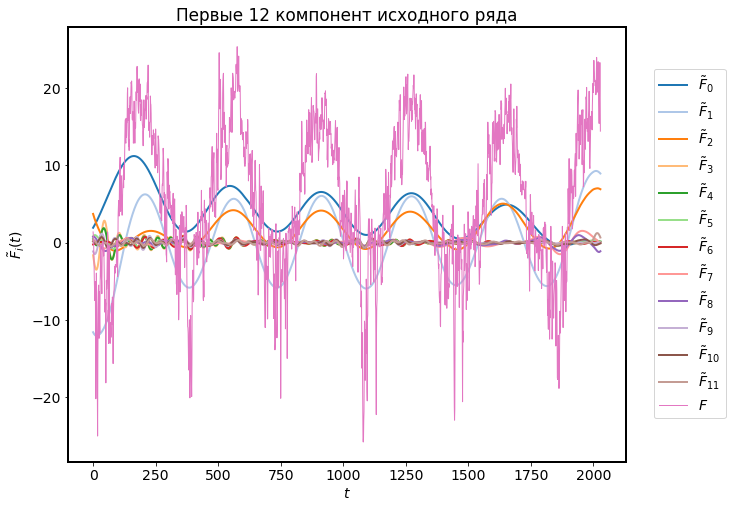

In [10]:
n = min(12,d)
fig = plt.subplot()
color_cycle = cycler(color=plt.get_cmap('tab20').colors)
fig.axes.set_prop_cycle(color_cycle)

# Преобразуем элементарне матрицы прямо во временные ряды - не нужно строить какие-либо матрицы Ханкеля.
for i in range(n):
    F_i = X_to_TS(X_elem[i])
    fig.axes.plot(F_i, lw=2)

fig.axes.plot(F, alpha=1, lw=1)
fig.set_xlabel("$t$")
fig.set_ylabel(r"$\tilde{F}_i(t)$")
legend = [r"$\tilde{F}_{%s}$" %i for i in range(n)] + ["$F$"]
fig.set_title("Первые 12 компонент исходного ряда")
fig.legend(legend, loc=(1.05,0.1));

На рисунке видно, что х0 и х1 практически повторяют друг друга, х2 близко к х1 х0,
х3 и х4 почти не заметны на фоне шумов

# 3. Разделение и группировка компонентов временных рядов

Мы можем группировать собственные элементы/компоненты временного ряда вместе путем визуального осмотра.
Однако для более длинных и сложных временных рядов мы хотим иметь метод, который количественно определяет, можно
 ли считать реконструированный компонент $\tilde{F}_i$ отдельным от другого компонента $\tilde{F}_j$.

Для двух реконструированных временных рядов, $\tilde{F}_i$ и $\tilde{F}_j$, длиной $N$ и длиной окна $L$, мы определяем *взвешенное скалярное произведение*, $(\tilde{F}_i, \tilde{F}_j)_w$ как:
$$(\tilde{F}_i, \tilde{F}_j)_w = \sum {k=0}^{N-1} w_k \tilde{f}_{i,k} \tilde{f}_{j,k}$$
где $\tilde{f}_{i,k}$ и $\tilde{f}_{j,k}$ находятся в $k$ - ых значениях $\tilde{F}_i$ и $\tilde{F}_j$, соответственно, и $w_k$ дается
$$
w_{k} = \left\{
  \begin{array}{lr}
    k+1 & \ 0 \le k \le L-1 \\
    L & \ L \le k \le K-1 \\
    N - k & \ K \le k \le N-1 \\
  \end{array}
\right.
$$
помня, что $K = N - L + 1$. Вес $w_k$ просто отражает количество раз, когда $\tilde{f}_{i,k}$ и $\tilde{f}_{j,k}$ появляются в матрицах Ганкеля $\mathbf{\tilde{X}}_i$ и $\mathbf{\tilde{X}}_j$, из которых были получены временные ряды $\tilde{F}_i$ и $\tilde{F}_j$.

Проще говоря, если $(\tilde{F}_i, \tilde{F}_j)_w = 0$, $\tilde{F}_i$ и $\tilde{F}_j$ являются *w-ортогональными* и компоненты временных рядов разделимы. Конечно, полная w-ортогональность не встречается в реальной жизни, поэтому вместо этого мы определяем матрицу $d \times d$ ***взвешенной корреляции***, $\mathbf{W}_{\text{corr}}$, которая измеряет отклонение компонентов $\tilde{F}_i$ и $\tilde{F}_j$ от w-ортогональности. Элементы $\mathbf{i}_{\text{Corr}}$ дает
$$W_{i,j} = \frac{(\tilde{F}_i, \tilde{F}_j)_w}{\lVert \tilde{F}_i \rVert_w \lVert \tilde{F}_j \rVert_w}$$
where $\lVert \tilde{F}_k \rVert_w = \sqrt{(\tilde{F}_k, \tilde{F}_k)_w}$ for $k = i,j$.
Интерпретация  $W_{i,j}$ проста: если $\tilde{F}_i$ и $\tilde{F}_j$ сколь угодно близки (но не идентичны),
то  $(\tilde{F}_i, \tilde{F}_j)_w \rightarrow \lVert \tilde{F}_i \rVert_w \lVert \tilde{F}_j \rVert_w$
и поэтому $W_{i,j} \rightarrow 1$. Если $\tilde{F}_i$ и $\tilde{F}_j$ ортогональны, тогда $W_{i,j} = 0$. Значения $W_{i,j}$ находятся в пределах от 0 до 1 и указывают $W_{i,j} \ge 0.3$ какие компоненты надо сгруппировать.

In [11]:
# Сначала получите веса w, так как они будут часто использоваться повторно.
# Примечание: список(np.arange(L)+1) возвращает последовательность от 1 до L (первая строка в определении w),
# [L]*(K-L-1) повторяет L K-L-1 раз (вторая строка в определении w)
# список(np.arange(L)+1)[::-1] отменяет первый список (эквивалентно третьей строке)
# Сложите все списки вместе, и у нас будет наш массив весов.
w = np.array(list(np.arange(L)+1) + [L]*(K-L-1) + list(np.arange(L)+1)[::-1])

# Получите все компоненты серии, сохраните их в виде столбцов в массиве F_elem.
F_elem = np.array([X_to_TS(X_elem[i]) for i in range(d)])

# Вычислите индивидуальные взвешенные нормы, ||F_i||_w, сначала, затем возьмите обратный квадратный корень, чтобы нам не пришлось делать это позже.
F_wnorms = np.array([w.dot(F_elem[i]**2) for i in range(d)])
F_wnorms = F_wnorms**-0.5

# Вычислите матрицу w-corr. Диагональные элементы равны 1, поэтому мы можем начать с матрицы идентичности
# и повторите все пары i и j (i != j), отметив, что Wij = Wji.
Wcorr = np.identity(d)
for i in range(d):
    for j in range(i+1,d):
        Wcorr[i,j] = abs(w.dot(F_elem[i]*F_elem[j]) * F_wnorms[i] * F_wnorms[j])
        Wcorr[j,i] = Wcorr[i,j]

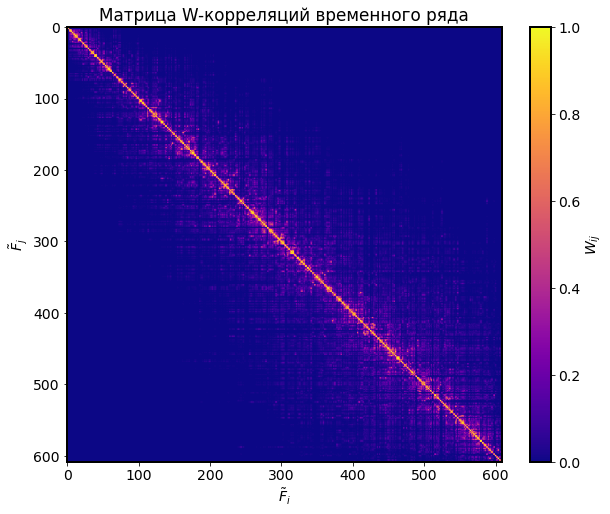

In [12]:
ax = plt.imshow(Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.clim(0,1)
plt.title("Матрица W-корреляций временного ряда");

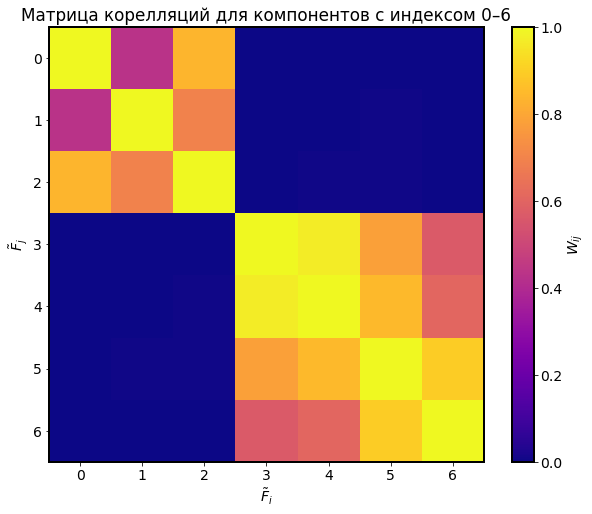

In [13]:
ax = plt.imshow(Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.xlim(-0.5,6.5)
plt.ylim(6.5,-0.5)
plt.clim(0,1)
plt.title(r"Матрица корелляций для компонентов с индексом 0–6");

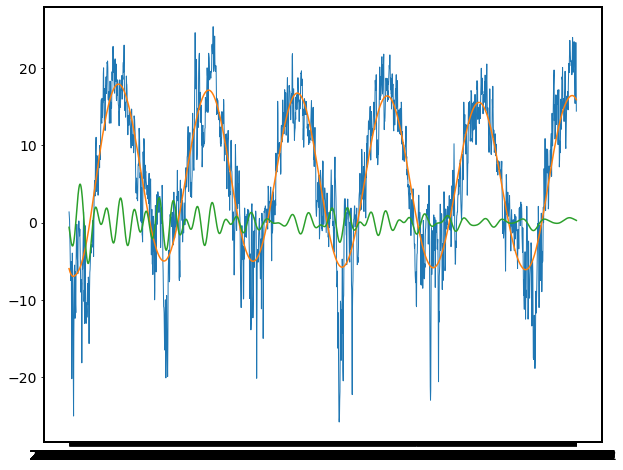

In [ ]:
# Группируем элементы между собой, основываясь на значениях корреляции
result_groups = components_auto_group(Wcorr)
F_trend = X_to_TS(X_elem[result_groups[0]].sum(axis=0))
F_periodic1 = X_to_TS(X_elem[result_groups[1]].sum(axis=0))
# получили следующие значения - [[0, 1, 2], [3, 4, 5, 6]]
plt.plot(data.TEMP, lw=1)
plt.plot(F_trend)
plt.plot(F_periodic1)

if len(result_groups) > 3:
    F_periodic2 = X_to_TS(X_elem[result_groups[2]].sum(axis=0))
    F_noise = X_to_TS(X_elem[result_groups[3][0]:].sum(axis=0))
    groups = ["тренд", "циклика 1", "циклика 2", "шум"]
    plt.plot(F_periodic2)
else:
    F_noise = X_to_TS(X_elem[result_groups[2][0]:].sum(axis=0))
    groups = ["тренд", "циклика 1", "шум"]

plt.plot(F_noise, alpha=0.5)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}^{(j)}$")
legend = ["$F$"] + [r"$\tilde{F}^{(\mathrm{%s})}$" % group for group in groups]
plt.legend(legend)
plt.title("Сгрупированные компоненты")

Мы достаточно хорошо отделили тренд от шума, однако остаются вопросы к х3 и х4 (периодикам)

# 4. Длина окна<a name="Section5"></a>
### 4.1 $L = 2$ <a name="Section5.1"></a>
Теперь рассмотрим различные длины окна
На окнах длиной 2-5 сложно хорошо отделить даже шумовую составляющую для нашего ряда

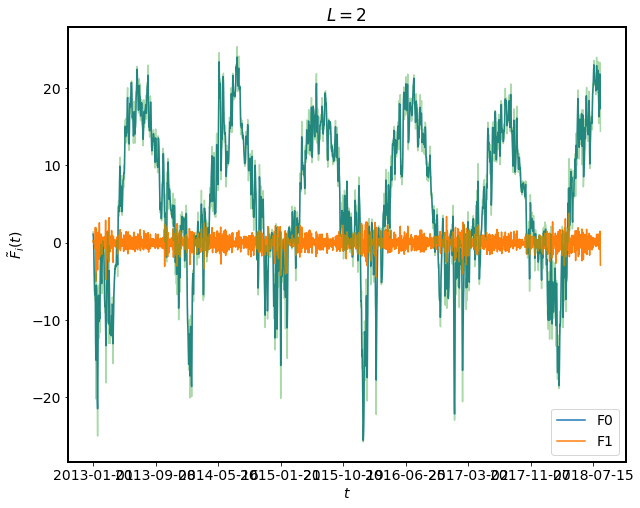

In [17]:
SSA_simple_plt(data.TEMP, window_size=2)

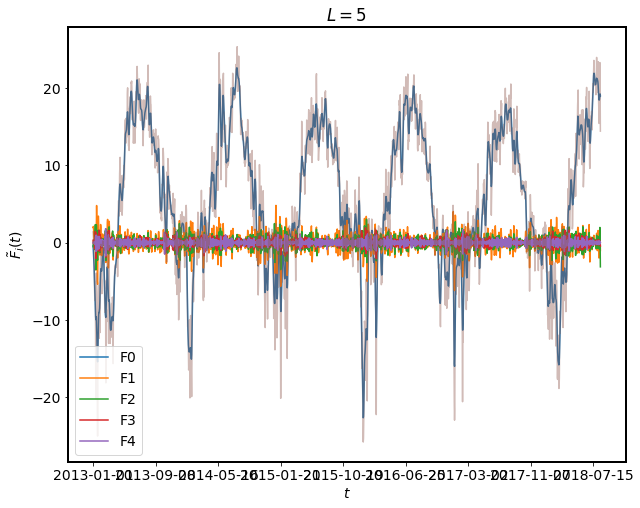

In [18]:
SSA_simple_plt(data.TEMP, window_size=5)

Теперь посмотрим на больших длинах окна, начиная от месяца и заканчивая 2 годами

window_size 30


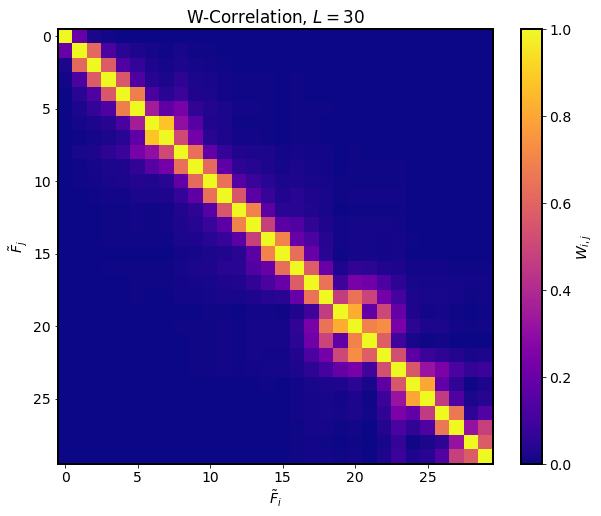

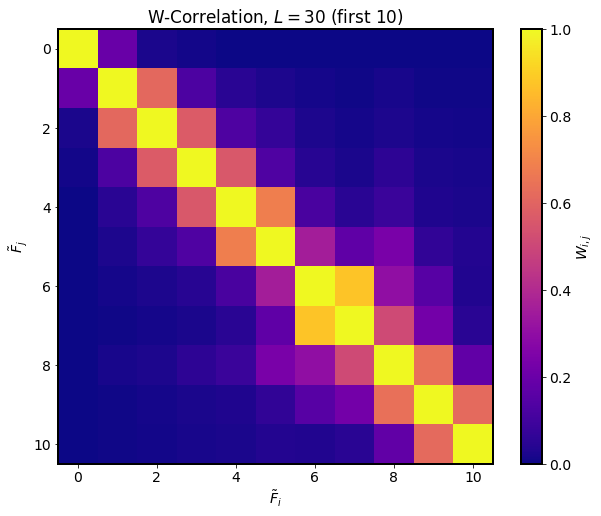

[[2, 1], [3, 2], [4, 3], [5, 4]]
[[0], [1, 2, 3, 4, 5]]


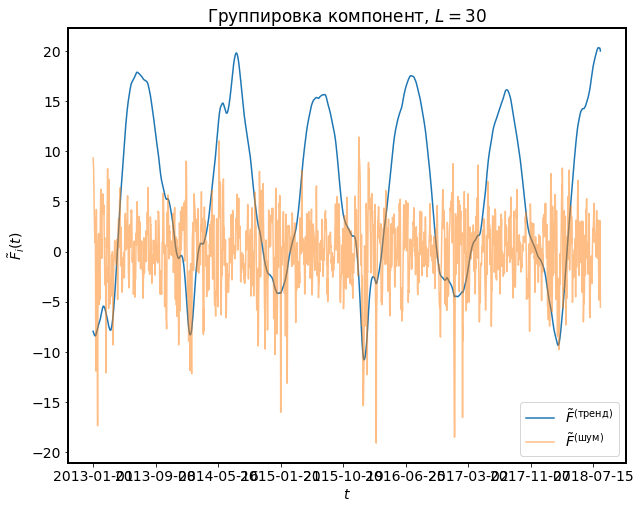

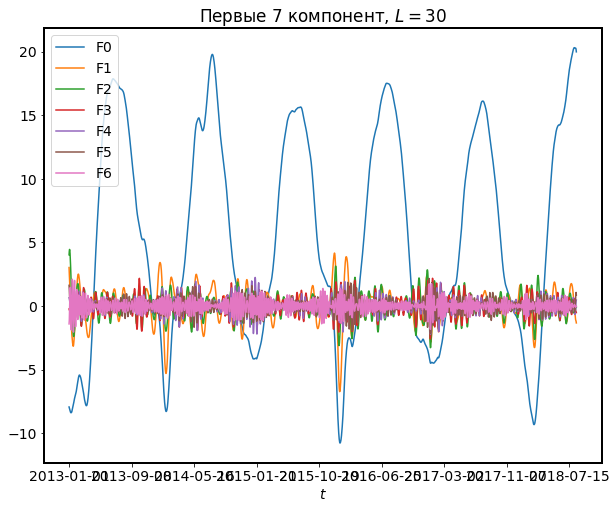

In [19]:
SSA_plt_groups(data.TEMP, window_size=30)

Здесь уже шум хорошо отделяется от тренда

window_size 60


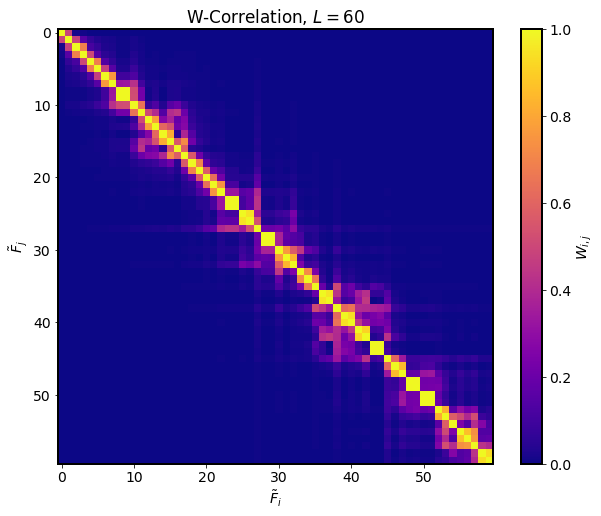

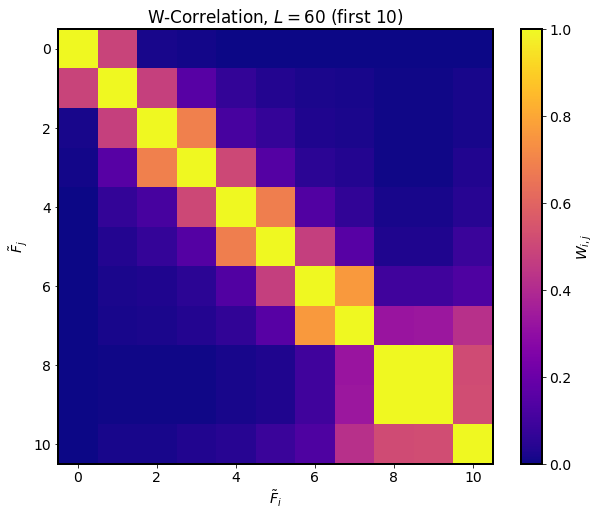

[[1, 0], [2, 1], [3, 2], [4, 3], [5, 4], [6, 5]]
[[0, 1, 2, 3, 4, 5, 6]]


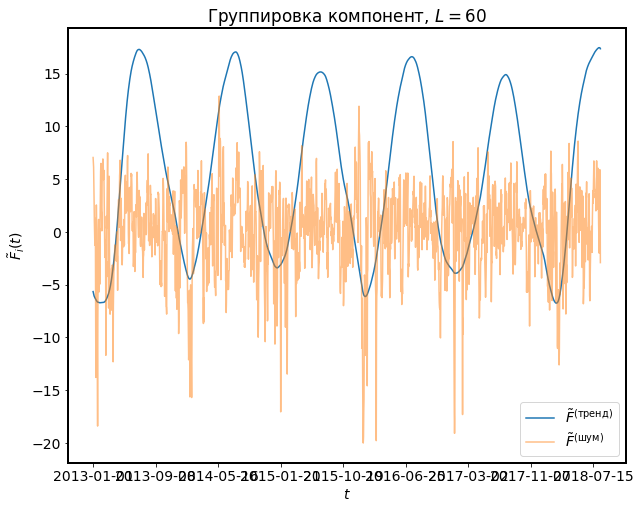

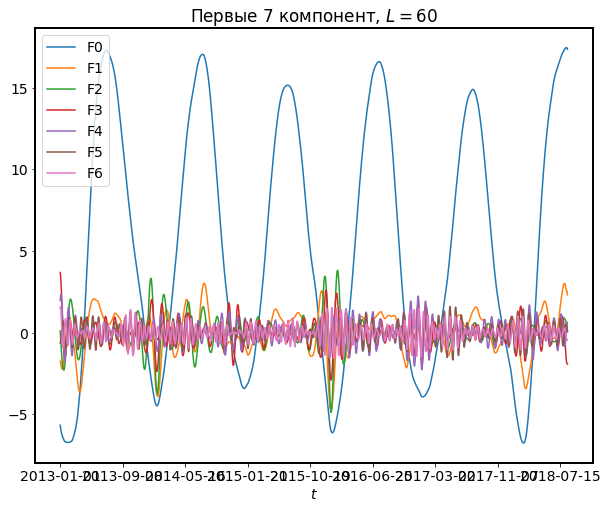

In [20]:
SSA_plt_groups(data.TEMP, window_size=60)

window_size 90


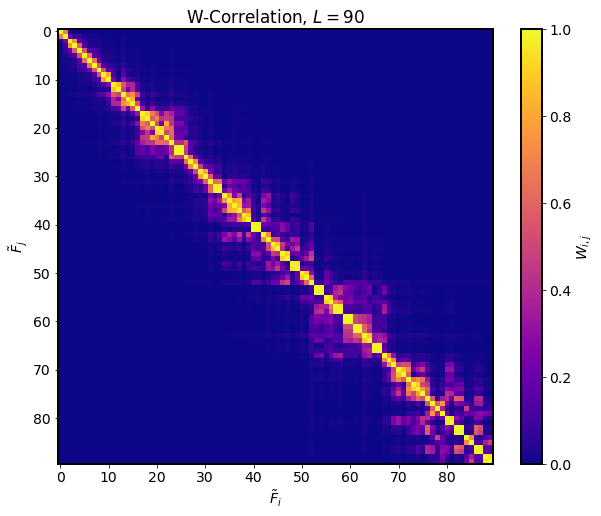

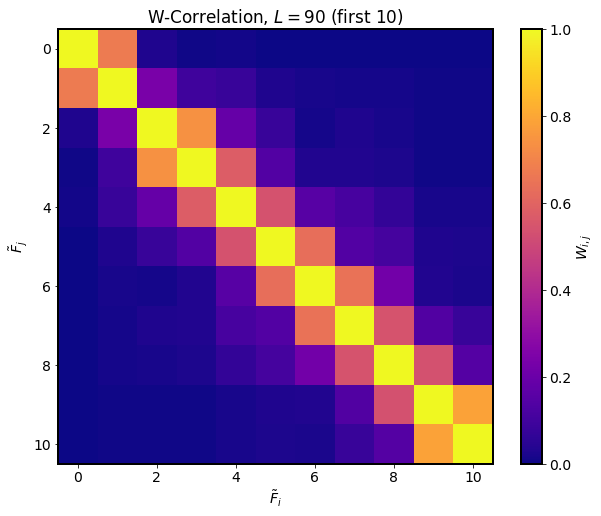

[[1, 0], [3, 2], [4, 3], [5, 4], [6, 5]]
[[0, 1], [2, 3, 4, 5, 6]]


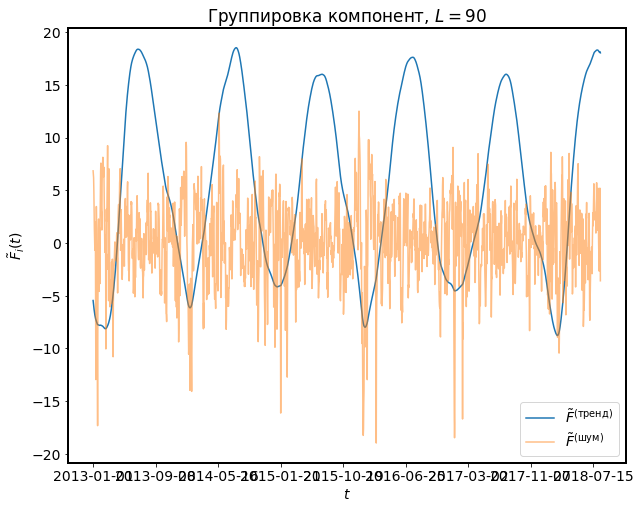

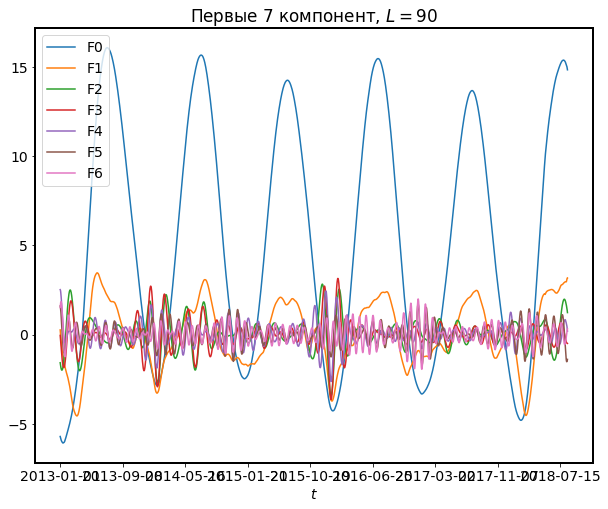

In [22]:
SSA_plt_groups(data.TEMP, window_size=90)

window_size 180


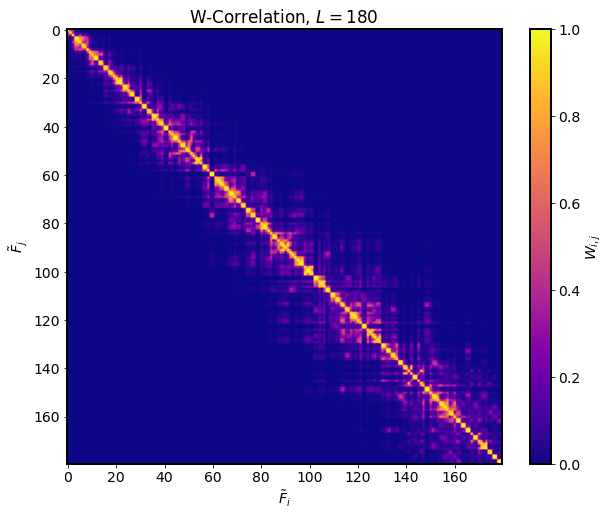

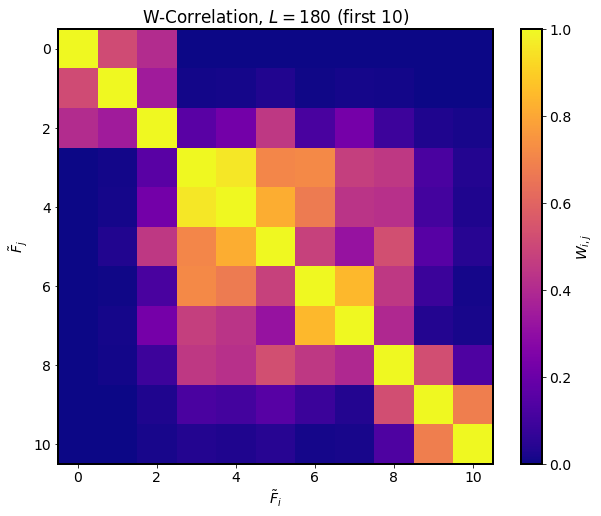

[[1, 0], [2, 0], [5, 2], [4, 3], [5, 3], [6, 3], [5, 4], [6, 4], [6, 5]]
[[0, 1, 2], [2, 5], [3, 4, 5, 6]]


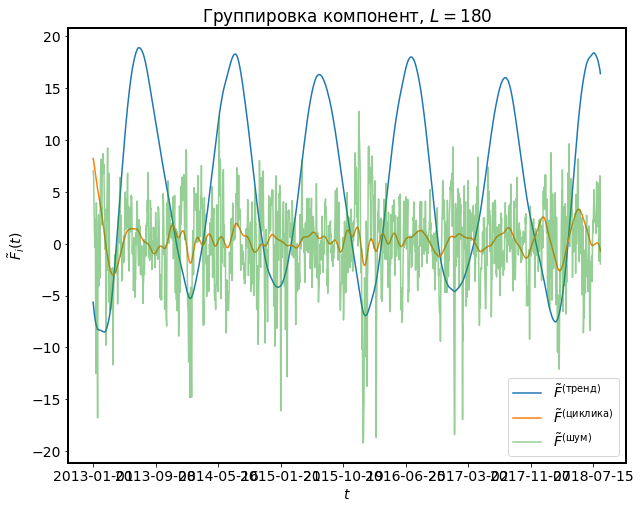

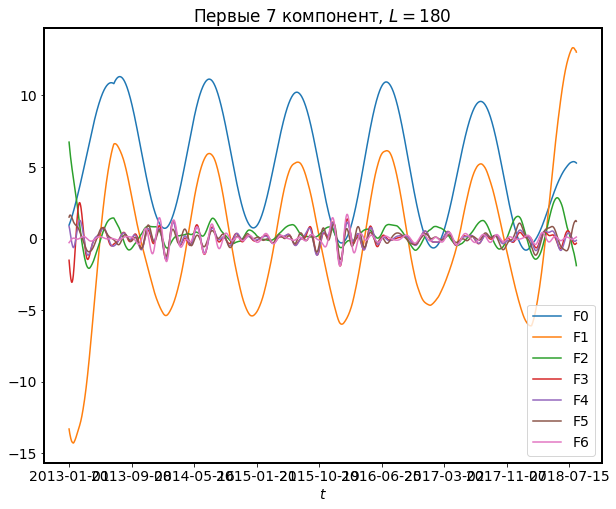

In [23]:
SSA_plt_groups(data.TEMP, window_size=180)

Дойдя до 180 мы четко видим х0 и х1 - трендовые компоненты, однако после х2 мы все еще видим только шум.
При L = 180 х2 начинает объединяться с трендом в группировке

window_size 365


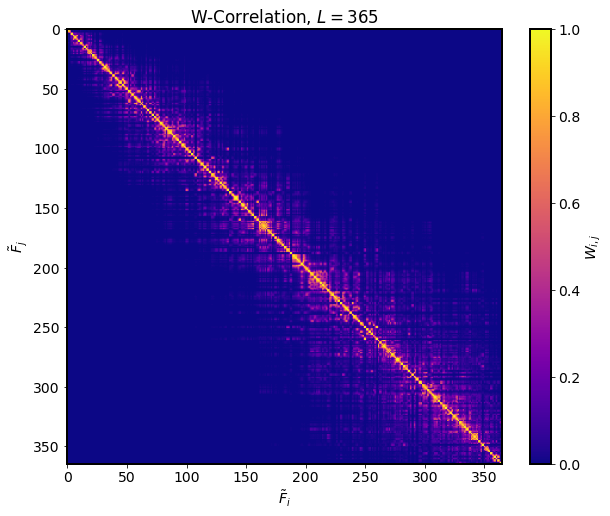

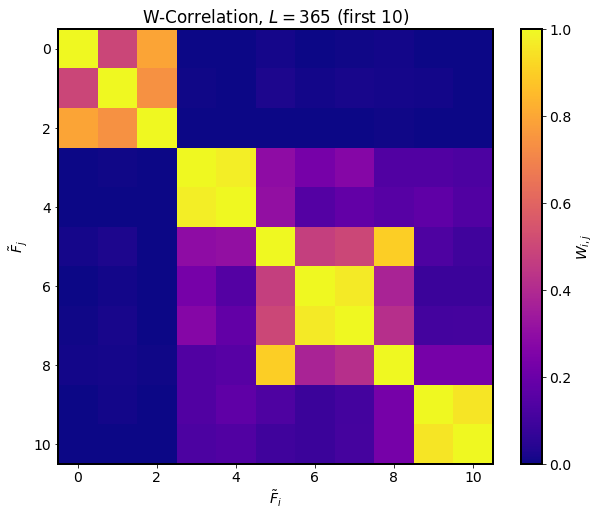

[[1, 0], [2, 0], [2, 1], [4, 3], [6, 5]]
[[0, 1, 2], [3, 4], [5, 6]]


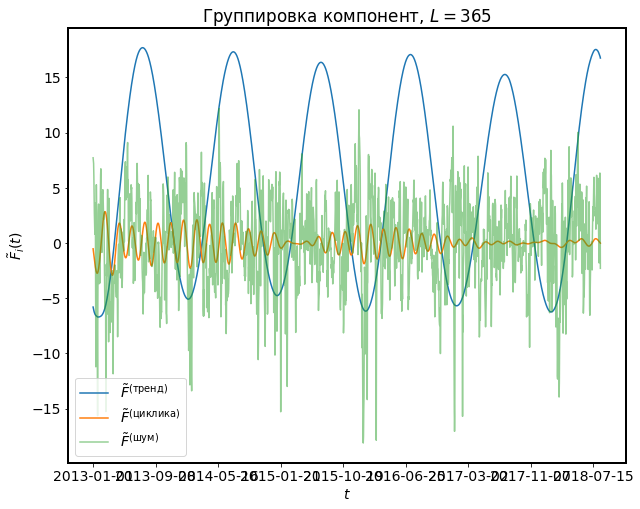

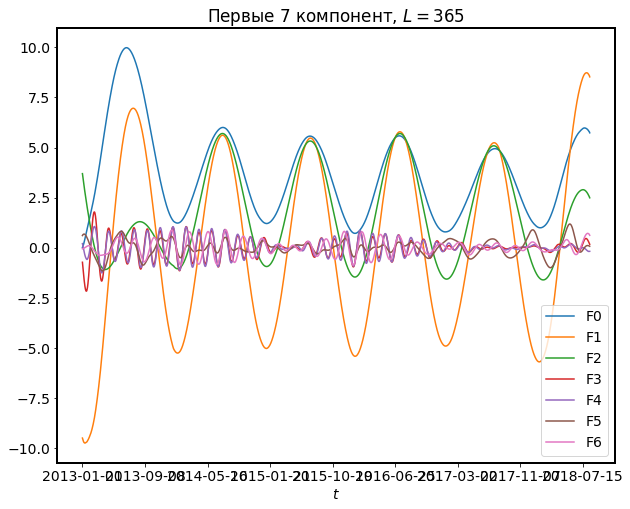

In [24]:
SSA_plt_groups(data.TEMP, window_size=365)

Здесь мы уже хорошо видим х2, который имеет высокую корреляцию с х0 и х1

window_size 550


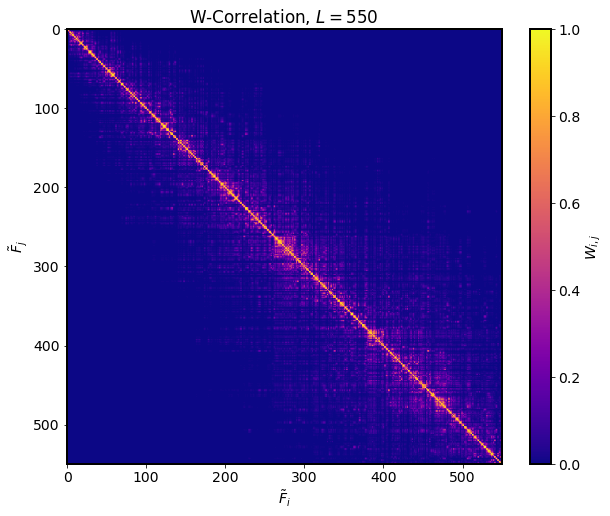

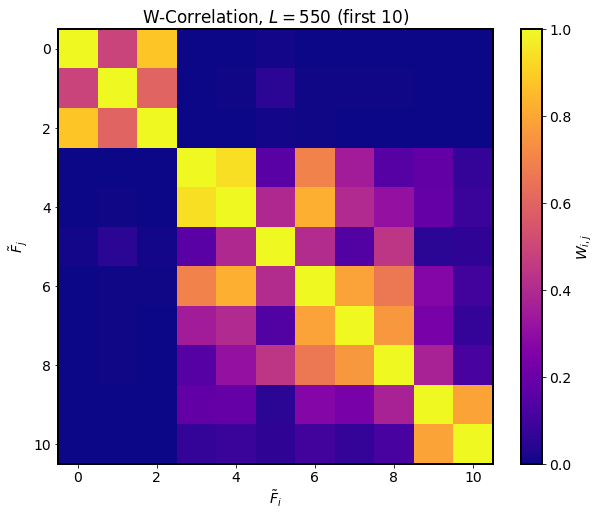

[[1, 0], [2, 0], [2, 1], [4, 3], [6, 3], [6, 4], [6, 5]]
[[0, 1, 2], [3, 4, 6]]


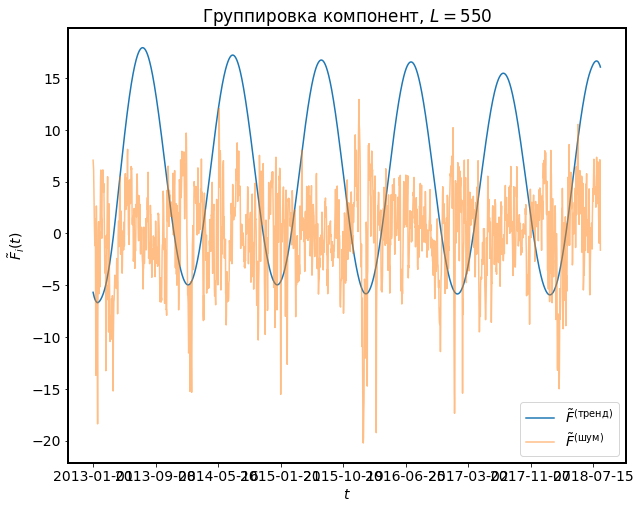

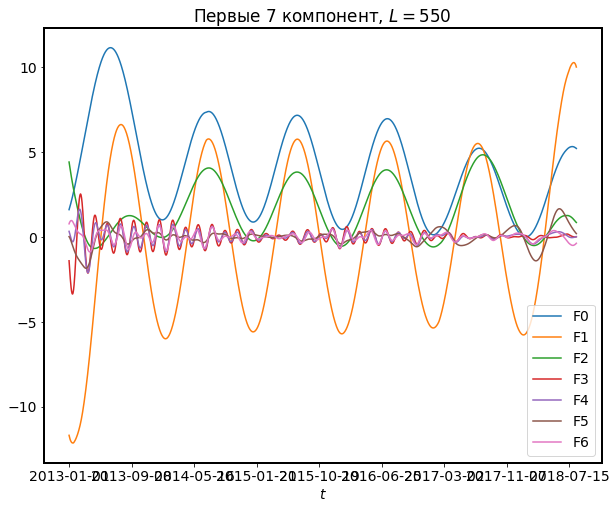

In [25]:
SSA_plt_groups(data.TEMP, window_size=550)

Начинает выделяться циклическая составляющая,
По результатам автоматической группировки выделяются х0-х2 как тренд и х3, х4 как циклика

window_size 730


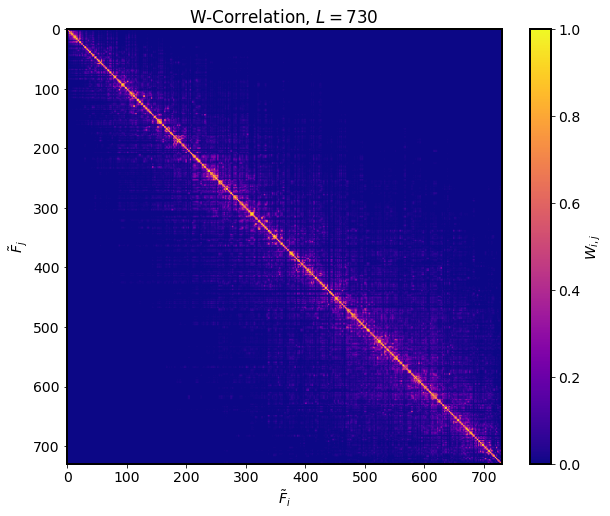

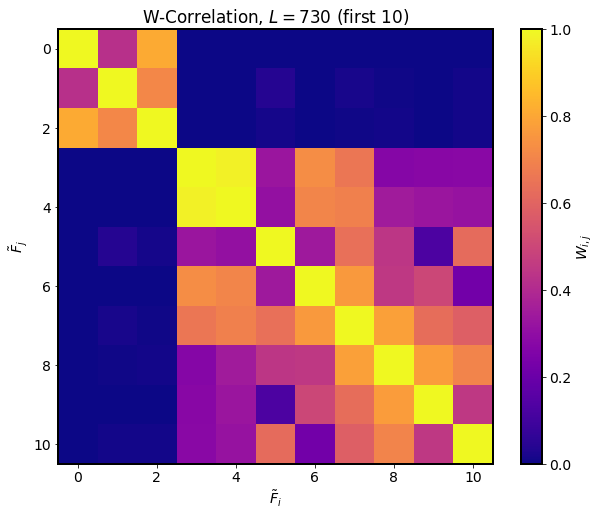

[[1, 0], [2, 0], [2, 1], [4, 3], [6, 3], [6, 4]]
[[0, 1, 2], [3, 4, 6]]


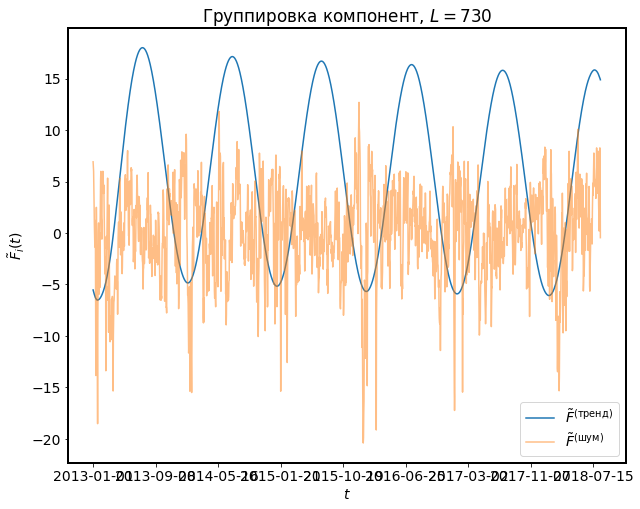

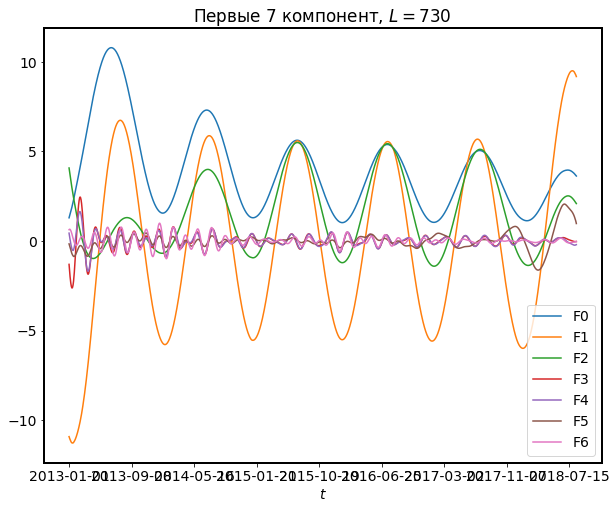

In [26]:
SSA_plt_groups(data.TEMP, window_size=730)

Возьмем "ровные" два года - здесь х2 уже имеет меньшую корреляцию с х0-х2
и, скорее, напоминает какую-то периодическую составляющую, при этом не связанную с х3-х4

window_size 1000


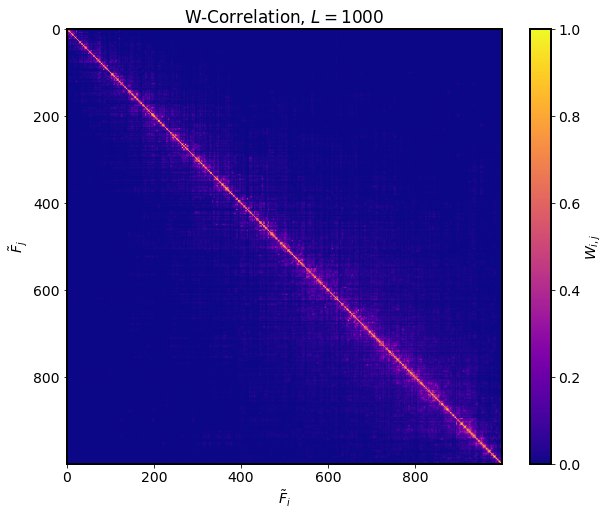

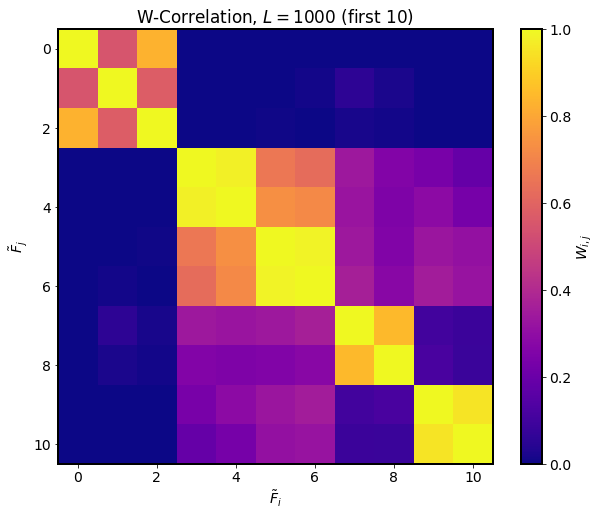

[[1, 0], [2, 0], [2, 1], [4, 3], [5, 3], [6, 3], [5, 4], [6, 4], [6, 5]]
[[0, 1, 2], [3, 4, 5, 6]]


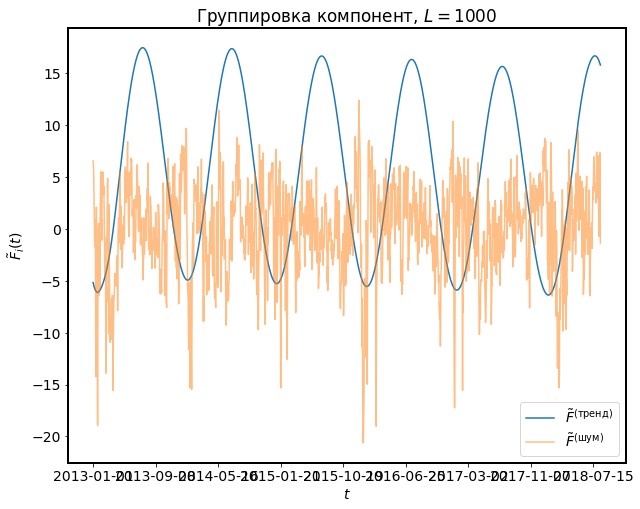

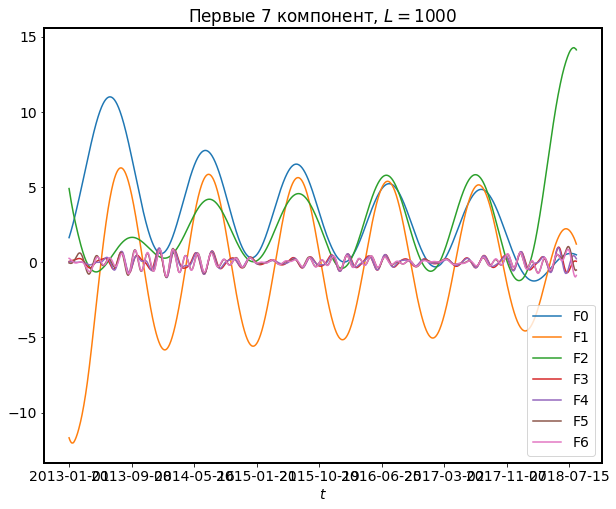

In [28]:
SSA_plt_groups(data.TEMP, window_size=1000)

2,5 года - теперь наши х3 х4 явно выделяются на фоне шума.
Тем не менее, х0, х1 и другие компоненты все равно все равно выглядят скорее как периодичность, чем тренд,
вероятно имеет смысл взять ряд большей длины, например, на 20-30 лет

Попробуем окно на 365, сгруппировав самостоятельно

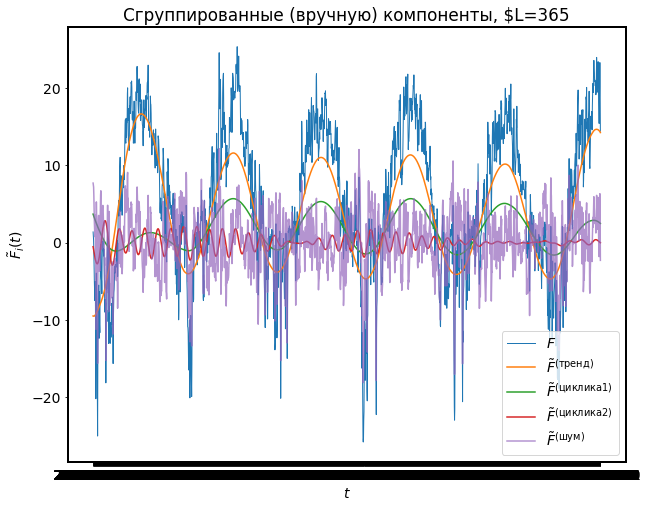

In [29]:
F_ssa_L365 = SSA(data.TEMP, 365)
plt.plot(data.TEMP, lw=1)
F_ssa_L365.reconstruct([0, 1]).plot()
F_ssa_L365.reconstruct([2]).plot()
F_ssa_L365.reconstruct([3, 4]).plot()
F_ssa_L365.reconstruct(slice(5, 365)).plot(alpha=0.7)
plt.title("Сгруппированные (вручную) компоненты, $L=365")
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
groups = ["тренд", "циклика 1", "циклика 2", "шум"]
legend = ["$F$"] + [r"$\tilde{F}^{(\mathrm{%s})}$" % group for group in groups]
plt.legend(legend)
plt.show()

Таким образом, мы неплохо отделили трендовые компоненты х0 и х1, выделили наши периодические компоненты.

В данном случае x3 и x4 все еще зашумлены, но мы уже видим некую периодичность.

# Часть 2: Тензорное разложение в Python

## Содержание
1. **Тензорное разложение**
2. **Реализация**
- Tensorly
- Numpy
3. **Результаты и сравнение**

В данной части рассматривается реализация тензорной декомпозиции в Python с использованием
библиотеки tensorly и простая реализация тензорной декомпозиции с помощью Numpy. Результаты этих
 подходов сравниваются с точки зрения ошибки восстановления и времени выполнения.

**Тензор**: Тензор - это **многомерный массив**. Также известен как **n-образный массив **, в котором "n" означает "размерность". Следовательно, почти все геометрические структуры данных, с которыми мы работаем, являются тензорами. Вплоть до $d = 2$ эти тензоры имеют определенные имена:
- тензор нулевой размерности: **скаляр**
- одномерный тензор: **вектор**
- двумерный тензор: **матрица**

По мере увеличения размеров структуры данных нам требуется больше значений,
чтобы найти один элемент нашей структуры данных. Например, мы можем найти любой элемент
матрицы, используя два значения $(i, j)$, и любой элемент тензора с помощью трех
значений $ (i, j, k)$.

**Разложение** в математическом анализе  означает факторизацию n-мерного тензора.
В системном анализе это состоит в нахождении оптимального разделения системы с точки зрения
ее подсистем. В целом, разложение нужно для получения более простого набора
составляющих, которые могут наилучшим образом представлять данную систему (или данные).

### Матричное разложение

Существуют различные методы для извлечения признаков или классификации:
- Анализ основных компонентов (PCA)
- Анализ независимых компонентов (ICA)
- Неотрицательна матричную факторизацию (NMF)
- Анализ разреженных компонентов (SCA).

Общая идея: Дано $X \in \mathbb{R}^{I \times J}$, хотим модель $M$ которая аппроксимирует $X$ такая что $\textbf{a} \in \mathbb{R}^I $ и $\textbf{b} \in \mathbb{R}^J$, так что:

$$ X \approx M = \sum_{r=1}^{R} a_r \cdot b_r^{T} = a_r \circ b_r = A \cdot B^T $$

$$ X \in \mathbb{R}^{I \times J}, \textbf{a} \in \mathbb{R}^I, \textbf{b} \in \mathbb{R}^J$$

Такое разложение известно как *Факторный анализ*. Приведенная выше формулировка страдает от проблемы, называемой **Проблемой вращения**. То есть мы можем вставить любую невырожденную матрицу вращения, $ Z $, в приведенную выше формулировку, и все равно получим то же приближение $X$ (учитывая, что столбцы Z имеют амплитуду 1).

$$ X \approx M = \sum_{r=1}^{R} a_r \circ z_r^T \circ z_r^{-1} \circ b_r^{T} = A \cdot Z^T \cdot Z^{-1} \cdot B^T $$

Следовательно, если приведенная выше формула не имеет ограничений, она приводит к бесконечному множеству комбинаций $A $ и $ B$. Стандартные матричные факторизации в линейной алгебре, такие как QR-факторизация, разложение на собственные значения (EVD) и разложение по сингулярным значениям (SVD), являются лишь частными случаями приведенной выше формулировки и обязаны своей уникальностью жестким ограничениям, таким как треугольность и ортогональность.

### Тензорное разложение

Мы хотим модель $M$ которая апроксимирует $X \in \mathbb{R}^{I \times J \times K}$, так что $\textbf{a} \in \mathbb{R}^I $, $\textbf{b} \in \mathbb{R}^J$, и $\textbf{c} \in \mathbb{R}^K$ таким образом:

$$ X \approx M = \sum_{r=1}^{R} a_r \circ b_r \circ c_r$$

$$X \in \mathbb{R}^{I \times J \times K}, \textbf{a} \in \mathbb{R}^I, \textbf{b} \in \mathbb{R}^J, \textbf{c} \in \mathbb{R}^K$$

R - это **ранг**.В результате у нас есть 3 матрицы $A \in \mathbb{R}^{I \times R}$, $B \in \mathbb{R}^{J \times R}$, $C \in \mathbb{R}^{K \times R}$.

<center>
    <img src="https://raw.githubusercontent.com/mohammadbashiri/tensor-decomposition-in-python/master/figures/tensor-decomposition.png" alt="tensor-decomposition" width="800" align="center"/>
</center>

## Как найти A, B и C?

In [246]:
import pandas as pd
import timeit

import tensorly as tl
from tensorly.decomposition import parafac
from tensortools.operations import khatri_rao
from tensor_utils import *

Прочитаем данные из csv файла. Используем следующие параметры:
1. Depth (метры) - глубина
2. CGR - Соотношение конденсата и газа
3. SW - водонасыщенность

И покажем их на графике

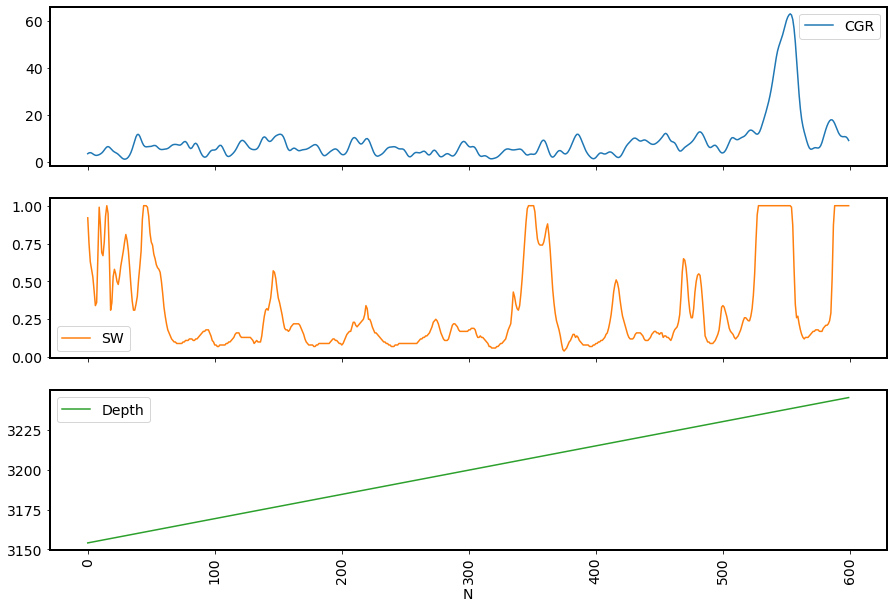

In [247]:
data = pd.read_excel("data/well_log.xlsx", sheet_name=0, nrows=600)
plot_df = data[['CGR', 'SW', 'Depth']]
plot_df.plot(subplots=True, figsize=(15, 10))
plt.xlabel("N")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

Мы взяли 600 значений на глубине от ~3100 до ~3200. Водонасыщенность и соотношение
конденсата и газа имеют корреляцию 0.5

In [248]:
CGR = np.array(data.CGR).reshape(-1,3)
SW = np.array(data.SW).reshape(-1,3)
Dep = np.array(data.Depth).reshape(-1,3) # phie, cgr, DT

observed = np.einsum('ir,jr,vr', CGR, SW,  Dep)
print(observed.shape)

(200, 200, 200)


Сохраним матрицы $A$, $B$, $C$ для последующего сравнения.

In [131]:
factors_actual = (normalize(CGR), normalize(SW), normalize(Dep))

## Реализация тензорного разложения с помощью библиотеки Tensorly

Вызовем функцию разложения и передадим тензор и ранг (количество факторов).
В **Tensorly** функция называется "parafac", которая реализует каноническое полиадическое (CP) разложение с помощью  ALS метода. Существует история возникновения этого названия, но оно также известно как Каноническая декомпозиция (CANDECOMP), а также параллельная факторизация (PARAFAC).

Ниже приведен минимальный код для реализации CP разложения тензора:
- Указываем тензор и ранг (количество факторов)
- Используем функцию для разложения тензора
- Кроме того, мы можем восстановить оценку $M$, используя готовую функцию "reconstruct".

In [249]:
X, rank = observed, 3 # Указываем Тензор и ранг

In [263]:
# TensorLy
weights, factors_tl = parafac(X, rank=rank) # Используем функцию для разложения тензора
# Восстановим исходный набор данных, используя reconstruct
M_tl = reconstruct(factors_tl)
# Определяем ошибку восстановления
rec_error_tl = np.mean((X-M_tl)**2)

Text(0.5, 1.1, 'Factors computed with TensorLy')

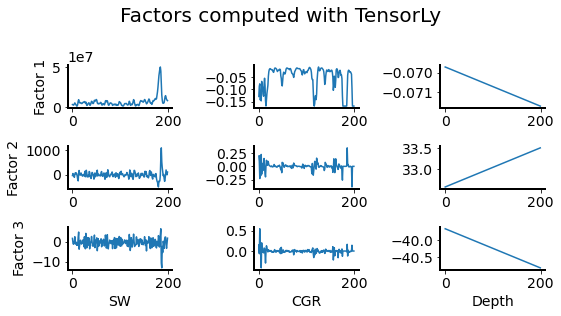

In [264]:
# Визуализируем факторы полученные с помощью Tensorly
plot_factors(factors_tl, d=3)
plt.suptitle("Factors computed with TensorLy", y=1.1, fontsize=20)

Оказывается, иногда факторы могут быть инвертированы. Однако, если один из них перевернут, то,
безусловно, другой также должен быть перевернут. Следовательно, в зависимости от ожиданий и
 интерпретации, может потребоваться изменить некоторые факторы.
 Столбцы соответствуют факторам, а строки матрицам ($A$, $B$, $C$).


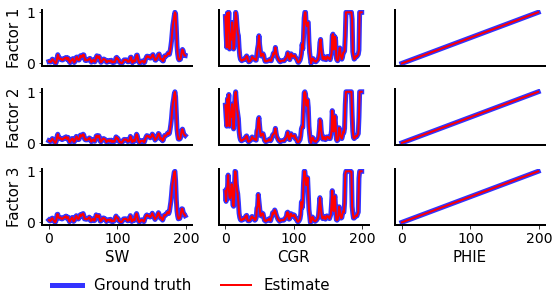

In [266]:
a, b, c = factors_tl
factors = (normalize(a), normalize(b), normalize(c))
fig, axes = plt.subplots(rank, 3, figsize=(8, int(rank * 1.2 + 1)))
compare_factors(factors, factors_actual, factors_ind=[1, 0, 2], fig=fig);

В результате мы видим, что наши значения соответствуют реальным. Теперь попробуем через numpy
### Тензорное разложение через Numpy

В конечном счете, мы хотели бы свести к минимуму разницу между $ X $  и $ M $ (оценка модели, которая является приближением $ X $). Следовательно, мы можем сформулировать нашу функцию потерь как квадрат ошибки между $X$ и $M$:

$ M $ вычисляется с использованием трех матриц $A $, $ B $ и $ C$, все из которых мы не знаем. Один из способов найти их - оптимизировать для одной, одновременно исправляя две других. Как только мы оптимизируем одну из них, мы используем ее как фиксированную матрицу, оптимизируя для другой. И мы чередуем оптимизацию $A$, $B $ и $ C$ до сходимости или критерия остановки. Следовательно, мы собираемся записать нашу функцию потерь для каждой матрицы следующим образом:

In [40]:
def decompose_three_way(tensor, rank, max_iter=501, verbose=False):

    # a = np.random.random((rank, tensor.shape[0]))
    b = np.random.random((rank, tensor.shape[1]))
    c = np.random.random((rank, tensor.shape[2]))

    for epoch in range(max_iter):
        # optimize a
        input_a = khatri_rao([b.T, c.T])
        target_a = tl.unfold(tensor, mode=0).T
        a = np.linalg.solve(input_a.T.dot(input_a), input_a.T.dot(target_a))

        # optimize b
        input_b = khatri_rao([a.T, c.T])
        target_b = tl.unfold(tensor, mode=1).T
        b = np.linalg.solve(input_b.T.dot(input_b), input_b.T.dot(target_b))

        # optimize c
        input_c = khatri_rao([a.T, b.T])
        target_c = tl.unfold(tensor, mode=2).T
        c = np.linalg.solve(input_c.T.dot(input_c), input_c.T.dot(target_c))

        if verbose and epoch % int(max_iter * .2) == 0:
            res_a = np.square(input_a.dot(a) - target_a)
            res_b = np.square(input_b.dot(b) - target_b)
            res_c = np.square(input_c.dot(c) - target_c)
            print("Epoch:", epoch, "| Loss (C):", res_a.mean(), "| Loss (B):", res_b.mean(), "| Loss (C):", res_c.mean())

    return a.T, b.T, c.T#%%

In [267]:
factors_np = decompose_three_way(X, rank, verbose=False)

In [268]:
a, b, c = factors_np
factors = (normalize(a), normalize(b), normalize(c))
M_np = reconstruct(factors_np)
rec_error_np = np.mean((X-M_np)**2)

Сравнение между подходами при оценке $X$.

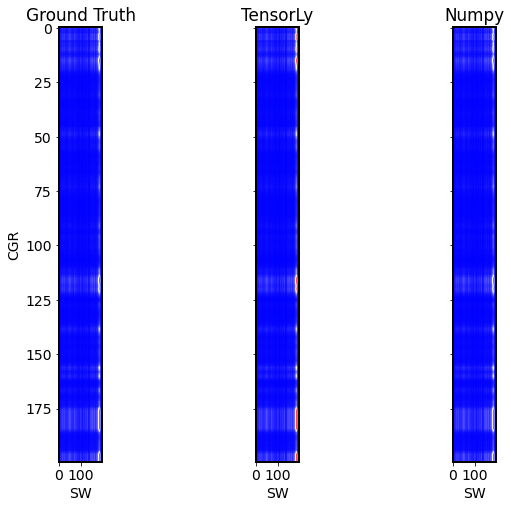

In [269]:
fig, axes = plt.subplots(1, 3, sharey=True)
tensors = [X, M_tl, M_np]
titles = ["Ground Truth", "TensorLy", "Numpy"]
trial_num = 50

for title, tensor, ax in zip(titles, tensors, axes):
    ax.imshow(tensor[:, :, trial_num].T, cmap='bwr', aspect=10)
    ax.set_xlabel("SW")
    ax.set_title(title)
axes[0].set_ylabel("CGR");

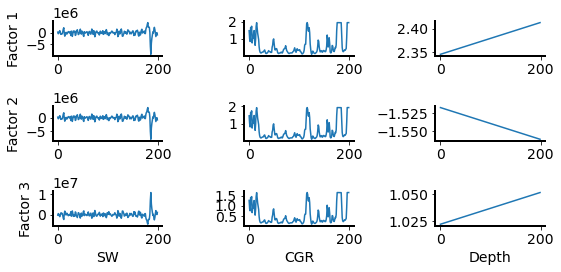

In [270]:
plot_factors(factors_np, d=3)


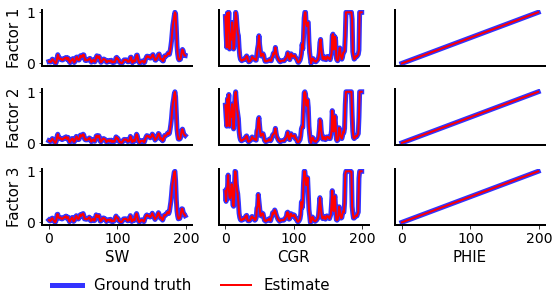

In [271]:
fig, axes = plt.subplots(rank, 3, figsize=(8, int(rank * 1.2 + 1)))
compare_factors(factors, factors_actual, factors_ind=[1, 0, 2], fig=fig);

### Сравнение подходов
#### Ошибка восстановления

In [272]:
iter_num = 50
times = {'tl': [], 'tt': [], 'np': []}
rec_errors = {'tl': [], 'tt': [], 'np': []}

# TensorLy
for i in range(iter_num):
    start_time = timeit.default_timer()
    weights, factors_tl = parafac(X, rank=rank, n_iter_max=200)
    end_time = timeit.default_timer() - start_time
    times['tl'].append(end_time)
    M_tl = reconstruct(factors_tl)
    rec_error_tl = np.mean((X-M_tl)**2)
    rec_errors['tl'].append(rec_error_tl)
    print("TensorLy | Iteration: {} / {} | time take: {} sec".format(i+1, iter_num, end_time))

# # Numpy
for i in range(iter_num):
    start_time = timeit.default_timer()
    factors_np = decompose_three_way(X, rank, max_iter=200, verbose=False)
    end_time = timeit.default_timer() - start_time
    times['np'].append(end_time)
    M_np = reconstruct(factors_np)
    rec_error_np = np.mean((X-M_np)**2)
    rec_errors['np'].append(rec_error_np)
    print("Numpy | Iteration: {} / {} | time take: {} sec".format(i+1, iter_num, end_time))

TensorLy | Iteration: 1 / 50 | time take: 1.291171700002451 sec
TensorLy | Iteration: 2 / 50 | time take: 1.2736552000060328 sec
TensorLy | Iteration: 3 / 50 | time take: 0.9367447999975411 sec
TensorLy | Iteration: 4 / 50 | time take: 1.1125581999949645 sec
TensorLy | Iteration: 5 / 50 | time take: 1.4288932999988901 sec
TensorLy | Iteration: 6 / 50 | time take: 1.1974562000032165 sec
TensorLy | Iteration: 7 / 50 | time take: 1.1269592000026023 sec
TensorLy | Iteration: 8 / 50 | time take: 0.8570082000005641 sec
TensorLy | Iteration: 9 / 50 | time take: 0.8117151999977068 sec
TensorLy | Iteration: 10 / 50 | time take: 0.8610787000070559 sec
TensorLy | Iteration: 11 / 50 | time take: 1.0102968999999575 sec


C:\Users\User\anaconda3\lib\site-packages\tensorly\backend\core.py:910: RuntimeWarning: invalid value encountered in sqrt
  S = np.where(np.abs(S) <= np.finfo(S.dtype).eps, 0, np.sqrt(S))
C:\Users\User\anaconda3\lib\site-packages\tensorly\backend\core.py:911: RuntimeWarning: invalid value encountered in less_equal
  V = np.dot(matrix.T.conj(), U * np.where(np.abs(S) <= np.finfo(S.dtype).eps, 0, 1/S)[None, :])


TensorLy | Iteration: 12 / 50 | time take: 1.0043705999996746 sec
TensorLy | Iteration: 13 / 50 | time take: 0.9235747000057017 sec
TensorLy | Iteration: 14 / 50 | time take: 0.8027414000025601 sec
TensorLy | Iteration: 15 / 50 | time take: 0.8429262999998173 sec
TensorLy | Iteration: 16 / 50 | time take: 0.8795008999950369 sec
TensorLy | Iteration: 17 / 50 | time take: 0.8330918999999994 sec
TensorLy | Iteration: 18 / 50 | time take: 0.8342505999971763 sec
TensorLy | Iteration: 19 / 50 | time take: 1.0749335000000428 sec
TensorLy | Iteration: 20 / 50 | time take: 1.374278700001014 sec
TensorLy | Iteration: 21 / 50 | time take: 1.3014672999997856 sec
TensorLy | Iteration: 22 / 50 | time take: 0.8678193999949144 sec
TensorLy | Iteration: 23 / 50 | time take: 0.9353618000022834 sec
TensorLy | Iteration: 24 / 50 | time take: 0.9374757000041427 sec
TensorLy | Iteration: 25 / 50 | time take: 0.9022893000001204 sec
TensorLy | Iteration: 26 / 50 | time take: 1.063108000002103 sec
TensorLy | I

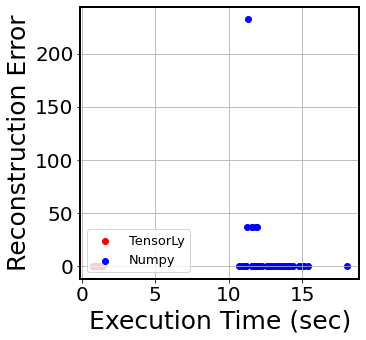

In [273]:
plt.figure(figsize=(5, 5)) #, dpi=200)
factor = 1e15
plt.scatter(np.array(times['tl']), np.array(rec_errors['tl']), c='red', label="TensorLy")
plt.scatter(np.array(times['np']), np.array(rec_errors['np']), c='b', label="Numpy")
plt.xlabel("Execution Time (sec)", fontsize=25)
plt.ylabel("Reconstruction Error", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc="lower left", fontsize=13)
plt.grid()
plt.savefig("metric-1.png", transparent=True, bbox_inches='tight')

Из рисунка можно увидеть, что tensorly справляется с задачей гораздо лучше, как по времени, так и по
значению ошибки восстановления. На используемом наборе данных затраты по времени для библиотеки tensorly
составляют около 1 секунды, в то время как для numpy это минимум 10 секунд. Ошибка восстановления для
tensorly стабильная, не меняется в зависимости от числа запусков. NumPy показывает близкую ошибку для большей части
запусков, однако мы видим большой разброс ошибок. Исходя из полученного графика можно сделать вывод,
что tensorly справляется с задачей лучше.

# Часть 3. Многомерные фильтры Калмана

In [ ]:
%matplotlib inline

## Введение

Фильтр Калмана представляет собой эффективный рекурсивный фильтр, оценивающий вектор
состояния динамической системы, используя ряд неполных и зашумленных измерений.

Динамическая система (ДС) - это любой объект или процесс, для которого однозначно
определено понятие состояния как совокупности некоторых величин в данный момент времени,
 и задан закон, который описывает изменение (эволюцию) начального состояния с течением времени.
 Этот закон позволяет по начальному состоянию прогнозировать будущее состояние ДС и его
  называют законом эволюции.
В смысле задания закона эволюции ДС могут описываться с помощью дифференциальных уравнений, дискретных отображений, с помощью теории графов, теории марковских цепей и т.д. Выбор одного из способов описания задает конкретный вид математической модели соответствующей ДС.

В большинстве приложений размерность вектора состояния объекта превосходит размерность вектора данных наблюдения,
при этом фильтр Калмана позволяет оценивать полное внутреннее состояние объекта.
Фильтр Калмана предназначен для рекурсивного дооценивания вектора состояния априорно
известной динамической системы, то есть для расчёта текущего состояния системы необходимо знать
текущее измерение, а также предыдущее состояние самого фильтра.
Таким образом, фильтр Калмана, подобно другим рекурсивным фильтрам, реализован во временно́м,
 а не в частотном представлении, но в отличие от других подобных фильтров,
  фильтр Калмана оперирует не только оценками состояния, а ещё и оценками
  неопределённости (плотности распределения) вектора состояния, опираясь на формулу Байеса
   условной вероятности.

Алгоритм работает в два этапа.
 На этапе прогнозирования фильтр Калмана экстраполирует значения переменных состояния,
 а также их неопределённости.
 На втором этапе по данным измерения (полученного с некоторой погрешностью)
 результат экстраполяции уточняется. Благодаря пошаговой природе алгоритма,
 он может в реальном времени отслеживать состояние объекта (без заглядывания вперед,
 используя только текущие замеры и информацию о предыдущем состоянии и его неопределенности).
В данной работе используется многомерная форма фильтра Калмана.

## Алгоритм фильтра Калмана

**Инициализация**

1. Инициализируйте состояние фильтра
2. Инициализируйте начальные условия(распределения, коорреляции)

**Прогнозировать**

1. Используйте модель динамики процесса для прогнозирования состояния на следующем временном шаге
2. Скорректируйте вывод модели, чтобы учесть неопределенность в прогнозе

**Обновление**

1. Получите измерение и связанную с ним неопределенность
2. Вычислите остаток между оценкой и измерением
3. Вычислите коэффициент масштабирования на основе того, соответствует ли измерение или прогноз более точен
4. Установите состояние между прогнозом и измерением на основе коэффициента масштабирования
5. Обновите параметры распределения

Многомерные гауссианы используют вектор для среднего и матрицу для ковариаций. Это означает, что фильтр Калмана должен использовать линейную алгебру для выполнения оценок.


<u>**Прогноз**</u>

$\begin{array}{|l|l|l|}
\hline
\text{Univariate} & \text{Univariate} & \text{Multivariate}\\
& \text{(Kalman form)} & \\
\hline
\bar \mu = \mu + \mu_{f_x} & \bar x = x + dx & \bar{\mathbf x} = \mathbf{Fx} + \mathbf{Bu}\\
\bar\sigma^2 = \sigma_x^2 + \sigma_{f_x}^2 & \bar P = P + Q & \bar{\mathbf P} = \mathbf{FPF}^\mathsf T + \mathbf Q \\
\hline
\end{array}$



$\mathbf x,\, \mathbf P$ являются средним состоянием и ковариацией. Они соответствуют $x$ и $\sigma^2$.

$\mathbf F$ является *функцией перехода состояния*. При умножении на $\bf x$ он вычисляет предыдущее состояние. 

$\mathbf Q$ отображает наличие ковариаций в процессе. Это соответствует $\sigma^2_{f_x}$.

$\mathbf B$ и $\mathbf u$ являются новыми для нас. Они позволяют нам моделировать управляющие входы в систему.

<u>**Обновление состояния**</u>

$\begin{array}{|l|l|l|}
\hline
\text{Univariate} & \text{Univariate} & \text{Multivariate}\\
& \text{(Kalman form)} & \\
\hline
& y = z - \bar x & \mathbf y = \mathbf z - \mathbf{H\bar x} \\
& K = \frac{\bar P}{\bar P+R}&
\mathbf K = \mathbf{\bar{P}H}^\mathsf T (\mathbf{H\bar{P}H}^\mathsf T + \mathbf R)^{-1} \\
\mu=\frac{\bar\sigma^2\, \mu_z + \sigma_z^2 \, \bar\mu} {\bar\sigma^2 + \sigma_z^2} & x = \bar x + Ky & \mathbf x = \bar{\mathbf x} + \mathbf{Ky} \\
\sigma^2 = \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2} & P = (1-K)\bar P &
\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar{P}} \\
\hline
\end{array}$

$\mathbf H$ является функцией измерения. Если убрать $\mathbf H$ из уравнений, вы должны увидеть, что эти уравнения также похожи.

$\mathbf z,\, \mathbf R$ среднее значение измерений и ковариация шума. Они соотвествуют $z$ и $\sigma_z^2$ в одномерном фильтре (Я заменил $\mu$ на $x$ для одномерных уравнений, чтобы сделать обозначения максимально похожими).

$\mathbf y$ и $\mathbf K$ остатки и коэфициент масштабирования. 

Детали будут отличаться от одномерного фильтра, потому что это векторы и матрицы, но концепции точно такие же:

- Используйте гауссовский процесс, чтобы представить нашу оценку состояния и ошибки
- Используйте гауссовский процесс для представления измерения и его погрешности
- Используйте гауссовскую модель для представления модели процесса
- Используйте модель динамики процесса для прогнозирования следующего состояния (предыдущего)
- Сформируйте оценку в промежуточной точке между измерением и предыдущим

Необходимо задать начальное состояние $\left(\mathbf x, \mathbf P\right)$,
модель процесса $\left(\mathbf F, \mathbf Q\right)$, измерения
 $\left(\mathbf z, \mathbf R\right)$, и функции измерений $\mathbf H$. Если это система имеет обратную связь по контролю то тогда задаются $\mathbf B$ и $\mathbf u$.

In [274]:
# Необходимые импорты
import numpy as np
from numpy.random import randn
import pandas as pd
import matplotlib.pyplot as plt

from filterpy.kalman import KalmanFilter, predict, update
from filterpy.common import Q_discrete_white_noise, Saver
from filterpy.stats import plot_covariance
from kf_book.book_plots import figsize
import kf_book.book_plots as book_plots

В качестве данных здесь будут использоваться почасовые данные о температуре. Возьмем 300 записей.

In [275]:
n = 624
delete = 324
count = n - delete
data_all = pd.read_csv("data/temperature.csv", header=0, nrows=n)
data = data_all[delete:] # первые 24 с постоянным значением
data = data.reset_index()
zs = np.array(data[['Vancouver']])
zs = zs.reshape(1,-1)[0]

Отобразим имеющиеся значения

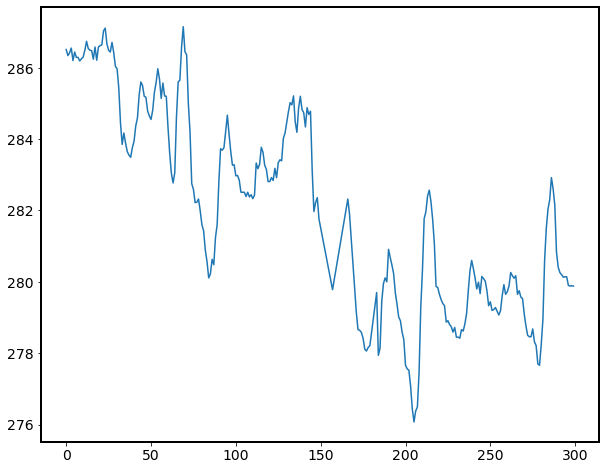

In [276]:
data.Vancouver.plot()

## Этап прогноза
Для прогнозирования необходимо спроектировать состояние и ковариацию,
 модель процесса и шум процесса, а также, возможно, управляющий вход. Рассмотрим их по порядку.

### Начальное состояние
Позиция - это *состояние* системы, и мы называем $\mu$ переменной *состояния*.

Это требует от нас использования многомерного ГР, представленного вектором состояния $\mathbf x$ и соответствующей ему ковариационной матрицей $\mathbf P$.

Переменные состояния могут быть либо
*наблюдаемыми переменными* - непосредственно измеряемыми датчиком,
либо *скрытыми переменными* - выводимыми из наблюдаемых переменных. В нашем случае имеется датчик для измерения
температуры, и также существует множество переменных, которые влияют на температуру воздуха. В данном случае
мы хотим отфильтровать полученные значения, исходя из того, что так как мы имеем почасовые данные, температура
не должна резко меняться и скорее всего такие изменения будут вызваны перебоями в датчике.

Фильтр Калмана реализован с использованием линейной алгебры.
Мы используем матрицу $n\times 1$ (называемую *вектором*) для хранения
переменных состояния $n$. Уравнения фильтра Калмана используют $\mathbf x$ для состояния,
поэтому мы определяем $\mathbf x$ как

$$\mathbf x =\begin{bmatrix}x \\ \dot x\end{bmatrix}$$

Мы используем $\mathbf x$ вместо $\mu$, это среднее значение многомерного гауссова.
 $\mathbf x$ - это стандартное имя переменной состояния,
 используемое в литературе по фильтру Калмана. Определим его как -

In [277]:
x = np.array([[280.0],
              [.5]])
x

array([[280. ],
       [  0.5]])

### Задаем матрицу ковариаций

Мы указываем начальное значение для $\mathbf P$, и фильтр обновляет его в течение каждой эпохи.

Нам нужно установить отклонения на разумные значения. Так как мы не уверены в текущей позиции и не имеем информации
относительно скрытой переменной, установим приблизительные значения, предполагая, что во время обновления
фильтра эти значения скорректируются.

Связь и ковариации фильтр вычисляет это для нас, поэтому я инициализирую ковариации до нуля.

Диагонали ковариационной матрицы содержат дисперсию каждой переменной,
а недиагональные элементы содержат ковариации. Таким образом, мы имеем:

In [278]:
P = np.array([[250., 0.],
              [0., 5.]])
P

array([[250.,   0.],
       [  0.,   5.]])

### Модель динамики процесса

Это математическая модель, которая описывает поведение системы. Фильтр использует его для прогнозирования состояния
 после дискретного временного шага.

Фильтры Калмана реализуют модель процесса с помощью этого линейного уравнения, где $\mathbf{\bar x}$ - это *предыдущее* или предсказанное состояние:

$$\mathbf{\bar x} = \mathbf{Fx}$$

$$\begin{bmatrix} \bar x \\ \dot{\bar x}\end{bmatrix} = \begin{bmatrix}? & ? \\? & ?\end{bmatrix}\begin{bmatrix}x\\\dot x\end{bmatrix}$$

Наша задача состоит в том, чтобы указать $\mathbf F$ таким образом,
 чтобы $\bar{\mathbf x}=\mathbf{Fx}$ выполнял прогнозирование для нашей системы.
 Для этого нам нужно одно уравнение для каждой переменной состояния.

У нас нет прогностической модели того, как скрытая переменная будет меняться с течением времени.
В этом случае мы предполагаем, что она остается постоянной между прогнозами.

$\mathbf F$ называется *функцией перехода состояния* или *матрицей перехода состояния*.

In [279]:
dt = 1.
F = np.array([[1, dt],
              [0, 1]])
F

array([[1., 1.],
       [0., 1.]])

Мы установили температуру на 280,0, а скрытую переменную - на 1.
Мы определили "dt = 1.", что означает, что временной шаг составляет 1 час,
поэтому мы ожидаем, что новая температура составит 280.5 градусов по Кельвину после нововведения.
Скрытая переменная должна быть неизменной.

In [280]:
x = np.array([[280.0],
              [.5]])
P = np.array([[250., 0.],
              [0., 5.]])
F = np.array([[1, dt], [0, 1]])

# Q is the process noise
x, P = predict(x=x, P=P, F=F, Q=0)
print('x =', x)

x = [[280.5]
 [  0.5]]


In [281]:
for _ in range(4):
    x, P = predict(x=x, P=P, F=F, Q=0)
    print('x =', x)

x = [[281. ]
 [  0.5]]
x = [[281.5]
 [  0.5]]
x = [[282. ]
 [  0.5]]
x = [[282.5]
 [  0.5]]


Значение $\mathbf P$ после пяти предсказаний, которое мы обозначаем $\mathbf{\bar P}$ в уравнениях фильтра Калмана.

In [282]:
print(P)

[[375.  25.]
 [ 25.   5.]]


Проверка диагоналей показывает нам, что дисперсия положения стала больше.
 Мы выполнили пять этапов прогнозирования без каких-либо измерений, и наша неопределенность возросла.
 Недиагональные элементы стали ненулевыми - фильтр Калмана обнаружил корреляцию между температурой и
 скрытой переменной. Отклонение скрытой переменной не изменилось.

Здесь я строю ковариацию до и после предсказания.
Начальное значение выделено сплошным красным цветом,
а предыдущее (прогноз) - черным пунктиром.
Я изменил ковариацию и временной шаг, чтобы лучше проиллюстрировать это изменение.

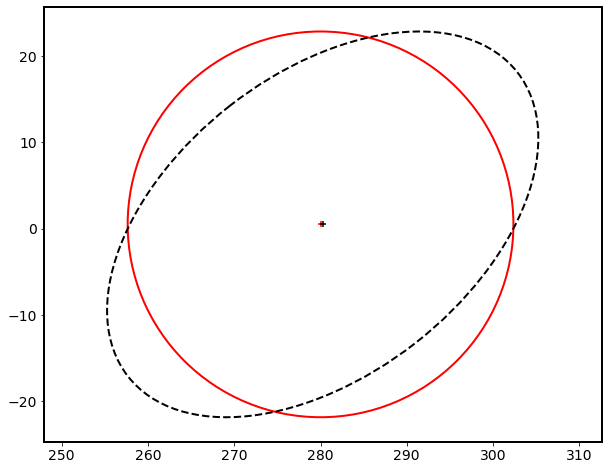

In [283]:
dt = 0.5
F = np.array([[1, dt], [0, 1]])
x = np.array([[280.0],
              [.5]])
P = np.array([[500., 0.],
              [0., 500.]])
plot_covariance(x, P, edgecolor='r')
x, P = predict(x, P, F, Q=0)
plot_covariance(x, P, edgecolor='k', ls='dashed')

Видно, что центр эллипса сместился на небольшую величину,
потому что положение изменилось. Эллипс также вытянулся, показывая корреляцию между положением и скоростью.

### Модель шума процесса

Краткий обзор *шума процесса*. Автомобиль едет по дороге с включенным круиз-контролем; он должен двигаться с постоянной скоростью. Мы моделируем это с помощью $\bar x_k=\dot x_k\delta t+x_{k-1}$. Однако на это влияет ряд неизвестных факторов. Круиз-контроль не может идеально поддерживать постоянную скорость. Ветер влияет на машину, как и холмы и выбоины. Пассажиры опускают стекла, изменяя профиль сопротивления автомобиля.

$$\dot{\mathbf x} = f(\mathbf x) + w$$

где $f(\mathbf x)$моделирует переход состояния, а $w$ - это *белый шум процесса*.

На данный момент вам просто нужно знать, что мы учитываем шум в системе, добавляя матрицу ковариации шума процесса $\mathbf Q$ к ковариации $\mathbf P$. Мы ничего не добавляем к $\mathbf x$, потому что шум *белый*, что означает, что среднее значение шума будет равно 0. Если среднее значение равно 0, $\mathbf x$ не изменится.

Одномерный фильтр Калмана использовал "дисперсию = дисперсию + process_noise" для вычисления дисперсии для дисперсии шага прогнозирования. Многомерный фильтр Калмана делает то же самое, по существу "P = P + Q". 

Вывод матрицы шума процесса может быть довольно сложным. На данный момент известно, что $\mathbf Q$ равно ожидаемому значению белого шума $w$, вычисленному как $\mathbf Q=\mathbb E[\mathbf{ww}^\mathsf T]$. 

"Q_discrete_white_noise" принимает 3 параметра. "dim", который определяет размер матрицы, "dt", который представляет собой временной шаг в секундах, и "var", отклонение в шуме. Вкратце, он дискретизирует шум в течение заданного периода времени в соответствии с предположениями, которые мы обсудим позже. Этот код вычисляет $\mathbf Q$ для белого шума с дисперсией 2,35 и шагом по времени 1 сек.:

In [284]:
Q = Q_discrete_white_noise(dim=2, dt=1., var=2.35)
print(Q)

[[0.5875 1.175 ]
 [1.175  2.35  ]]


### Функция контроля

Фильтр Калмана не просто фильтрует данные, он позволяет нам включать управляющие входы таких систем. На каждом временном шаге мы посылали бы сигналы управления и скорости в зависимости от его текущего положения по сравнению с желаемым положением. Уравнения фильтра Калмана включают эти знания в уравнения фильтра, создавая прогнозируемое положение, основанное как на текущей скорости, так и на управляющих входах для приводных двигателей.

Для линейной системы влияние управляющих входов может быть описано как набор линейных уравнений, которые мы можем выразить с помощью линейной алгебры как

$$\Delta\mathbf x=\mathbf{Bu}$$

Здесь $\mathbf u$ - это *управляющий вход*, а $\mathbf B$ - это *модель управляющего входа* или * функция управления*. Например, $\mathbf u$ может быть напряжением, управляющим скоростью вращения двигателя колеса, и умножение на $\mathbf B$ дает $\Delta[\begin{smallmatrix}x\\dot x\end{smallmatrix}]$. Другими словами, он должен вычислить, сколько $\mathbf x$ изменяется из-за управляющего ввода.

Поэтому полное уравнение фильтра Калмана для предыдущего среднего равно

$$\mathbf{\bar x}= \mathbf{Fx}+ \mathbf{Bu}$$


In [285]:
B = 0. 
u = 0
x, P = predict(x, P, F, Q, B, u)
print('x =', x)
print('P =', P)

x = [[280.5]
 [  0.5]]
P = [[1000.5875  501.175 ]
 [ 501.175   502.35  ]]


#### Prediction: Summary

* $\mathbf x$, $\mathbf P$: начальное состояние и матрица ковариаций
* $\mathbf F$,  $\mathbf Q$: модель динамики процесса и модель шума
* $\mathbf{B,u}$: Контроль

## Шаг обновления
Теперь мы можем реализовать этап обновления фильтра.

Фильтр Калмана вычисляет шаг обновления в том, что мы называем "пространством измерений".
Мы отслеживали температуру с помощью датчика.
Вычисление *остатка* было простым - вычтите прогнозируемое положение фильтра из измерения:

$$ \mathtt{residual} = \mathtt{measured\, \, } - \mathtt{predicted\, \, }$$

Нам нужно вычислить остаток, потому что мы масштабируем его по коэффициенту Калмана, чтобы получить новую оценку.

Что бы произошло, если бы мы пытались отслеживать температуру с помощью термометра, который выдает напряжение, соответствующее показаниям температуры? Уравнение для вычисления остатка было бы бессмысленным; вы не можете вычесть температуру из напряжения.

$$ \mathtt{residual} = \mathtt{voltage} - \mathtt{temperature}\;\;\;(NONSENSE!)$$


Нам нужно преобразовать температуру в напряжение, чтобы мы могли выполнить вычитание:

```python
# CELSIUS_TO_VOLTS = 0.21475
# residual = voltage - (CELSIUS_TO_VOLTS * predicted_temperature)
```

Фильтр Калмана обобщает эту проблему, предоставляя вам функцию измерения, которая преобразует состояние в измерение.

Почему мы работаем в пространстве измерений? Почему бы не работать в пространстве состояний, преобразуя напряжение в температуру, позволяя остаточному значению быть разницей в температуре?

Мы не можем этого сделать, потому что большинство измерений не являются *обратимыми*. Состояние проблемы отслеживания содержит скрытую переменную $\dot x$. Нет способа преобразовать измерение положения в состояние, содержащее скорость. С другой стороны, тривиально преобразовать состояние, содержащее положение и скорость, в эквивалентное "измерение", содержащее только положение. Мы должны работать в измерительном пространстве, чтобы сделать возможным вычисление остатка.

Как измерение $\mathbf z$, так и состояние $\mathbf x$ являются векторами, поэтому нам нужно использовать матрицу для выполнения преобразования. Уравнение фильтра Калмана, которое выполняет этот шаг, является:

$$\mathbf y=\mathbf z-\mathbf{H\bar x}$$

где $\mathbf y$ - остаток, $\mathbf{\bar x}$ - предшествующее состояние, $\mathbf z$ - измерение, а $\mathbf H$ - функция измерения. Итак, мы берем предыдущее, преобразуем его в измерение, умножив его на $\mathbf H$, и вычитаем это из измерения. Это дает нам разницу между нашим предсказанием и измерением в пространстве измерений!

Нам нужно спроектировать $\mathbf H$ так, чтобы $\mathbf{H\bar x}$ давал измерение.
Для этой задачи у нас есть датчик, который измеряет температуру, поэтому $\mathbf z$ будет вектором с одной переменной:

$$\mathbf z = \begin{bmatrix}z\end{bmatrix}$$

Уравнение остатков будет иметь вид

$$
\begin{aligned}
\textbf{y} &= \mathbf z - \mathbf{H\bar x}  \\
\begin{bmatrix}y \end{bmatrix} &= \begin{bmatrix}z\end{bmatrix} - \begin{bmatrix}?&?\end{bmatrix} \begin{bmatrix}x \\ \dot x\end{bmatrix}
\end{aligned}
$$

$\mathbf H$ должна быть матрица 1x2 для $\mathbf{Hx}$ быть 1х1.

Мы захотим умножить позицию $x$ на 1, чтобы получить соответствующее измерение температуры.
Нам не нужно использовать другую переменную, чтобы найти соответствующее измерение, поэтому мы умножаем $\dot x$ на 0.

$$\begin{aligned}
\textbf{y} &= \mathbf z - \begin{bmatrix}1&0\end{bmatrix} \begin{bmatrix}x \\ \dot x\end{bmatrix} \\
&= [z] - [x]
\end{aligned}$$

Итак, для нашего фильтра Калмана мы установили
$$\mathbf H=\begin{bmatrix}1&0\end{bmatrix}$$

In [286]:
H = np.array([[1., 0.]])

Мы разработали большую часть нашего фильтра Калмана. Все, что осталось, - это смоделировать шум в датчиках.

####  Начальное состояние

Измерение реализуется с помощью $\mathbf z$, среднего значения измерения, и $\mathbf R$, ковариации измерения.

$\mathbf z$ он содержит измерение(измерения) в виде вектора. У нас есть только одно измерение, поэтому у нас есть:

$$\mathbf z = \begin{bmatrix}z\end{bmatrix}$$


$$\mathbf z = \begin{bmatrix}z_1 \\ z_2\end{bmatrix}$$

*Матрица шума измерения* моделирует шум в наших датчиках в виде ковариационной матрицы. На практике это может быть непросто. В сложной системе может быть много датчиков, корреляция между ними может быть неясной, и обычно их шум не является чистым гауссовым. Например, датчик может быть смещен для считывания высоких значений, если температура высокая, и поэтому шум не распределяется равномерно по обе стороны от среднего значения.

Уравнения фильтра Калмана используют ковариационную матрицу $\mathbf R$ для шума измерения. Матрица будет иметь размерность $m{\times}m$, где $m$ - количество датчиков. Это ковариационная матрица для учета корреляций между датчиками. У нас есть только 1 датчик или есть:

$$R = \begin{bmatrix}\sigma^2_z\end{bmatrix}$$

Если $\sigma^2_z$ равно 5 квадратным метрам, у нас будет $R= \begin{bmatrix}5\end{bmatrix}$.

Если бы у нас было два датчика положения, первый с отклонением 5 m$^2$, второй с отклонением 3 m$^2$, мы бы написали

$$R = \begin{bmatrix}5&0\\0&3\end{bmatrix}$$

Мы помещаем отклонения по диагонали, потому что это матрица *ковариации*,
где отклонения лежат по диагонали, а ковариации, если таковые имеются, лежат в недиагональных элементах.
Здесь мы предполагаем, что между двумя датчиками нет корреляции в шуме, поэтому ковариации равны 0.

Для нашей проблемы у нас есть только один датчик, поэтому мы можем реализовать это как

In [287]:
R = np.array([[5.]])

In [288]:
z = 1.
x, P = update(x, P, z, R, H)
print('x =', x)

x = [[   2.38973486]
 [-138.80007334]]


## Реализация фильтра Калмана

In [289]:
obj_filter = KalmanFilter(dim_x=2, dim_z=1)
print('x = ', obj_filter.x.T)
print('R = ', obj_filter.R)
print('Q = \n', obj_filter.Q)

x =  [[0. 0.]]
R =  [[1.]]
Q = 
 [[1. 0.]
 [0. 1.]]


Теперь мы инициализируем матрицы и векторы фильтра значениями, допустимыми для нашей задачи.

In [290]:
def pos_vel_filter(x, P, R, Q=0., dt=1.0):
    """ Returns a KalmanFilter which implements a
    constant velocity model for a state [x dx].T
    """
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([x[0], x[1]]) # location and velocity
    kf.F = np.array([[1., dt],
                     [0.,  1.]])  # state transition matrix
    kf.H = np.array([[1., 0]])    # Measurement function
    kf.R *= R                     # measurement uncertainty
    if np.isscalar(P):
        kf.P *= P                 # covariance matrix 
    else:
        kf.P[:] = P               # [:] makes deep copy
    if np.isscalar(Q):
        kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q)
    else:
        kf.Q[:] = Q
    return kf

"Фильтр Калмана" инициализирует "R", "P" и "Q" в матрицу идентификаторов, поэтому "kf.P*= P" - это один из способов быстро присвоить всем диагональным элементам одно и то же скалярное значение. Теперь мы создаем фильтр:

In [291]:
def run(x0=(0.,0.), P=500, R=0, Q=0, dt=1.0, zs=None, count=0, do_plot=True, **kwargs):
    # create the Kalman filter
    kf = pos_vel_filter(x0, R=R, P=P, Q=Q, dt=dt)  

    # run the kalman filter and store the results
    xs, cov = [], []
    for z in zs:
        kf.predict()
        kf.update(z)
        xs.append(kf.x)
        cov.append(kf.P)

    xs, cov = np.array(xs), np.array(cov)

    if do_plot:
        with figsize(x=10, y=5):
            book_plots.plot_measurements(range(1, count + 1), zs)
            book_plots.plot_filter(range(1, count + 1), xs[:, 0])
            # plot_track(xs[:, 0], track, zs, cov, **kwargs)
    return xs, cov

У нас есть 300 измерений с дисперсией шума 5 и дисперсией процесса 0,1.

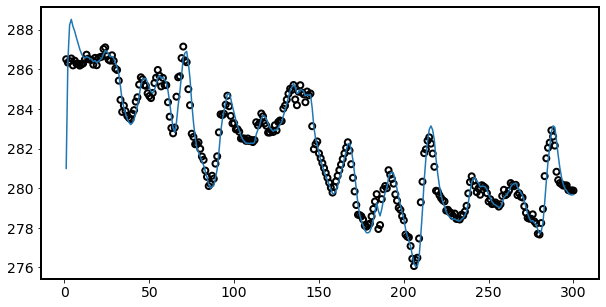

In [292]:
P = np.array([[250., 0.],
              [0., 5.]])
Ms, Ps = run(count=count, zs=zs, R=5, Q=0.1, P=P)

На первом графике вывод фильтра Калмана сопоставляется с измерениями.
Нам неизвестны реальные данные, но видно, что первоначальная точка достаточно далека от полученных значений.
Вероятно, нужно настроить параметры фильтра. После первых 20 значений фильтр самостоятельно обновляет параметры
и, таким образом, мы получаем хороший результат, наш ряд выглядит более сглаженным.

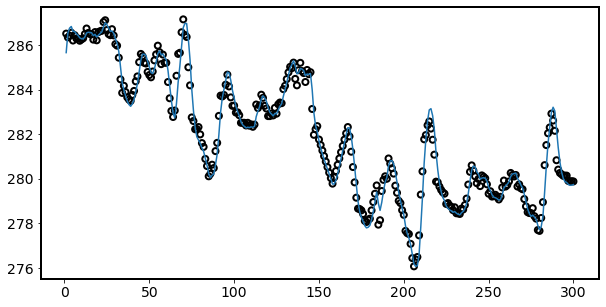

In [293]:
P = np.array([[1000., 0.],
              [0., 5.]])
Ms, Ps = run(count=count, zs=zs, R=3, Q=0.1, P=P)

Изменив значения матрицы ковариации и дисперсии шума мы получаем более реалистичные показания для первых 20 измерений,
при этом остальные значения визуально не отличаются от предыдущих.

In [294]:
kf = pos_vel_filter([0, .1], R=R, P=P, Q=Q, dt=1.) 
s = Saver(kf)
for i in range(1, 6):
    kf.predict()
    kf.update([i])
    s.save()  # save the current state

Объект "Saver" теперь содержит списки всех атрибутов объекта фильтра Калмана. "kf.x" - это оценка текущего состояния фильтра. Поэтому "s.x" содержит оценку сохраненного состояния, которая была вычислена внутри цикла:

In [295]:
s.x

[array([0.99554714, 0.10549928]),
 array([1.74940152, 0.53240985]),
 array([2.81641224, 0.86898738]),
 array([3.91096428, 0.99701149]),
 array([4.97183633, 1.03252729])]

In [296]:
s.P_post

[array([[4.97526191, 0.03055154],
        [0.03055154, 7.31226885]]),
 array([[3.60616562, 2.37448618],
        [2.37448618, 5.61717949]]),
 array([[3.72186946, 2.34323906],
        [2.34323906, 3.67124168]]),
 array([[3.58493951, 2.03471003],
        [2.03471003, 3.09553996]]),
 array([[3.46976871, 1.92969817],
        [1.92969817, 3.01209409]])]

In [297]:
s.keys

['alpha',
 'likelihood',
 'log_likelihood',
 'mahalanobis',
 'dim_x',
 'dim_z',
 'dim_u',
 'x',
 'P',
 'Q',
 'B',
 'F',
 'H',
 'R',
 '_alpha_sq',
 'M',
 'z',
 'K',
 'y',
 'S',
 'SI',
 '_I',
 'x_prior',
 'P_prior',
 'x_post',
 'P_post',
 '_log_likelihood',
 '_likelihood',
 '_mahalanobis',
 'inv']

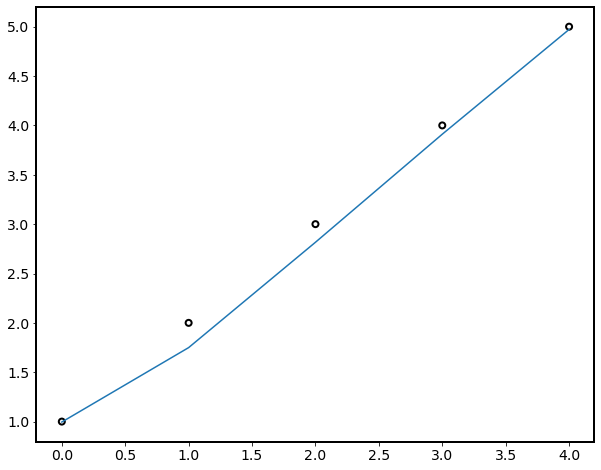

In [298]:
s.to_array()
book_plots.plot_measurements(s.z)
plt.plot(s.x[:, 0]);

## Уравнения фильтра Калмана

### Уравнения прогнозирования

Фильтр Калмана использует эти уравнения для вычисления *предыдущего* - предсказанного следующего состояния системы. Они вычисляют предыдущее среднее значение ($\bar{\mathbf x}$) и ковариацию ($\bar{\mathbf P}$) системы.

$$\begin{aligned}
\mathbf{\bar x} &= \mathbf{Fx} + \mathbf{Bu}\\
\mathbf{\bar P} &= \mathbf{FPF}^\mathsf T + \mathbf Q
\end{aligned}$$

$\underline{\textbf{Mean}}$

$\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu}$

Напомним, что линейное уравнение $\mathbf{Ax} = \mathbf b$ представляет собой систему уравнений, где $\mathbf A$ содержит набор коэффициентов уравнений, $\mathbf x$ - вектор переменных. Выполнение умножения $\mathbf{Ax}$ вычисляет значения правой части для этого набора уравнений, представленных $\mathbf b$.

Если $\mathbf F$ содержит переход состояния для заданного временного шага, то произведение $\mathbf{Fx}$ вычисляет состояние после этого перехода. Аналогично, $\mathbf B$ является функцией управления, $\mathbf u$ является управляющим входом, поэтому $\mathbf{Bu}$ вычисляет вклад элементов управления в состояние после перехода. Таким образом, $\mathbf{\bar x}$ вычисляется как сумма $\mathbf{Fx}$ и $\mathbf{Bu}$.

Эквивалентное одномерное уравнение имеет вид

$$\bar\mu = \mu + \mu_{move}$$

Если вы выполните умножение матрицы $\mathbf{Fx}$, оно сгенерирует это уравнение для $x$.

Давайте проясним это. Вспомните значение для $\mathbf F$ из предыдущей главы:

$$\mathbf F=\begin{bmatrix}1&\Delta t\\0&1\end{bmatrix}$$

Таким образом, $\mathbf{\bar x}= \mathbf{Fx}$ соответствует набору линейных уравнений:

$$\begin{cases}
\begin{aligned}
\bar x &= 1x + &\Delta t\, \dot x \\
\bar{\dot x} &=0x + &1\, \dot x
\end{aligned}
\end{cases}$$

$\underline{\textbf{Covariance}}$

$\mathbf{\bar P} = \mathbf{FPF}^\mathsf T + \mathbf Q$

Это уравнение не так просто понять, поэтому мы потратим на него больше времени.

В одномерной версии этого уравнения:

$$\bar\sigma^2 = \sigma^2 + \sigma^2_{move}$$

Мы добавляем отклонение движения к отклонению нашей оценки, чтобы отразить потерю знаний. Нам нужно сделать то же самое здесь, за исключением того, что это не так просто с многомерными гауссианами.

Мы не можем просто написать $\mathbf{\bar P} = \mathbf P + \mathbf Q$. В многомерном гауссовом уравнении переменные состояния *коррелированы*. Что это означает? Наше знание скорости несовершенно, но мы добавляем его к положению с

$$\bar x = \dot x\Delta t + x$$

Поскольку мы не обладаем знанием значения $\dot x$, сумма $\bar x = \dot x\Delta t + x$ приобретает неопределенность. Поскольку положения и скорости коррелированы, мы не можем просто добавить ковариационные матрицы. Например, если $\mathbf P$ и $\mathbf Q$ являются диагональными матрицами, сумма также будет диагональной. Но мы знаем, что положение коррелирует со скоростью, поэтому недиагональные элементы должны быть ненулевыми.

Правильное уравнение таково

$$\mathbf{\bar P} = \mathbf{FPF}^\mathsf T + \mathbf Q$$

Выражения в виде $\mathbf{ABA}^\mathsf T$ распространены в линейной алгебре. Вы можете думать об этом как о "проецировании". 

Когда мы инициализируем $\mathbf P$ с помощью

$$\mathbf P = \begin{bmatrix}\sigma^2_x & 0 \\ 0 & \sigma^2_v\end{bmatrix}$$


значение для $\mathbf{FPF}^\mathsf T$ равно:

$$\begin{aligned}
\mathbf{FPF}^\mathsf T &= \begin{bmatrix}1&\Delta t\\0&1\end{bmatrix}
\begin{bmatrix}\sigma^2_x & 0 \\  0 & \sigma^2_{v}\end{bmatrix}
\begin{bmatrix}1&0\\\Delta t&1\end{bmatrix} \\
&= \begin{bmatrix}\sigma^2_x&\sigma_v^2\Delta t\\  0 & \sigma^2_{v}\end{bmatrix}
\begin{bmatrix}1&0\\\Delta t&1\end{bmatrix} \\
&= \begin{bmatrix}\sigma^2_x +  \sigma_v^2\Delta t^2  &  \sigma_v^2\Delta t \\
\sigma_v^2\Delta t & \sigma^2_{v}\end{bmatrix}
\end{aligned}$$

Начальное значение для $\mathbf P$ не имело ковариации между положением и скоростью. Позиция вычисляется как $\dot x\Delta t+ x$, поэтому существует корреляция между положением и скоростью. Умножение $\mathbf{FPF}^\mathsf T$ вычисляет ковариацию $\sigma_v^2\Delta t$. Точное значение не важно; просто нужно признать, что $\mathbf{FPF}^\mathsf T$ использует модель процесса для автоматического вычисления ковариации между положением и скоростью

Другой способ подумать об этом - поразмыслить над умножением $\mathbf{Fx}$. Это предсказывало $\mathbf x$ вперед во времени. $\mathbf {FP}$ может показаться эквивалентной операцией, но $\mathbf P$ - это матрица, а $\mathbf x$ - вектор. $\mathbf F^\mathsf T$ гарантирует, что мы умножим как на строки, так и на столбцы $\mathbf F$. Во второй строке вычисления $\mathbf{FPF}^\mathsf T$ у нас есть значение для $\mathbf{FP}$. Вы можете видеть, что это верхняя треугольная матрица, потому что мы не полностью включили $\mathbf F$ в умножение.

Ковариация, обусловленная предсказанием, может быть смоделирована как ожидаемое значение ошибки на этапе прогнозирования, заданное этим уравнением.

$$\begin{aligned}
\bar{\mathbf P} &= \mathbb E[(\mathbf{Fx - \bar \mu})(\mathbf{Fx - \bar\mu})^\mathsf T]\\
 &= \mathbf F\, \mathbb E[\mathbf{(x- \bar\mu)(x- \bar\mu)}^\mathsf T]\, \mathbf F^\mathsf T
\end{aligned}$$

Конечно, $\mathbb E[\mathbf{(x-\bar\mu)(x-\bar\mu)}^\mathsf T]$ - это просто $\mathbf P$, дающий нам

$$\bar{\mathbf P} = \mathbf{FPF}^\mathsf T$$

Давайте посмотрим на его эффект. Здесь я использую $\mathbf F$ из нашего фильтра и
 проецирую состояние вперед на 1 час. Я делаю это пять раз, чтобы вы могли видеть,
  как $\mathbf{\bar P}$ продолжает меняться.

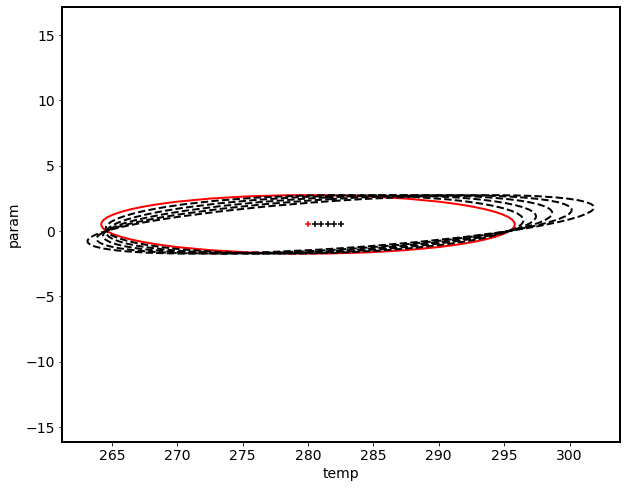

In [301]:
dt = 1.
x = np.array([[280.0],
              [.5]])
F = np.array([[1., dt], [0, 1.]])
P = np.array([[250, 0.],
              [0., 5]])

plot_covariance(x, P, edgecolor='r')
for _ in range(5):
    x = F @ x
    P = F @ P @ F.T
    plot_covariance(x, P, edgecolor='k', ls='dashed')
book_plots.set_labels(x='temp', y='param')

На оси х мы видим наши значения температуры.
Наш температурный ряд взят для Ванкувера за октябрь. Средняя температура в октябре около 11 градусов по Цельсию,
может достигать 5 ночью и 15 днем. В Кельвинах это от 278 до 288 градусов, что соответствует нашему
температурному ряду. Также мы видим отклонения температуры как в большую, так и в меньшую сторону.
Однако здесь присутствует больший разброс и встречаются не очень реалистичные значения, т.к
300 по Кельвину это почти 27 градусов по Цельсию, что не соответствует октябрьской температуре.
Это по большей части связано с используемыми значениями для P.
Приняв P как

P = np.array([[5, 0.],
              [0., 5]]),

близкие к значениям Р из Saver, мы увидим ожидаемые значения температуры.

 На каждом шаге ширина эллипса больше, что указывает на то, что мы потеряли информацию о температуре
  из-за добавления $\dot x\Delta t$ к x на каждом шаге.
  Высота не изменилась - наша модель говорит, что скрытый параметр не меняется,
  поэтому наше представление о нем не может измениться.
  Наклон указывает на корреляцию.

### Обновление системы
Уравнения обновления выглядят более запутанными, чем прогностические уравнения, но это в основном связано с фильтром Калмана, вычисляющим обновление в пространстве измерений. Это происходит потому, что измерения не являются *обратимыми*. Например, рассмотрим датчик, который определяет дальность до цели. Невозможно преобразовать диапазон в позицию - бесконечное количество позиций в круге даст один и тот же диапазон. С другой стороны, мы всегда можем вычислить диапазон (измерение), заданный положением (состоянием).

$\underline{\textbf{System Uncertainty}}$

$\textbf{S} = \mathbf{H\bar PH}^\mathsf Т+ \mathbf Р$

Для работы в пространстве измерений фильтр Калмана должен спроецировать ковариационную матрицу в пространство измерений. $\mathbf{H\bar PH}^\mathsf T$, где $\mathbf{\bar P}$ - это *предшествующая* ковариация, а $\mathbf H$ - функция измерения.


$\mathbf{ABA}^\mathsf T$ - шаг прогнозирования, используемый $\mathbf{FPF}^\mathsf T$ для обновления $\mathbf P$ с функцией перехода состояния. Здесь мы используем ту же форму, чтобы обновить ее с помощью функции измерения. Линейная алгебра меняет для нас систему координат.

Как только ковариация окажется в измерительном пространстве, нам нужно будет учесть шум датчика. Это очень просто - мы просто добавляем матрицы. Результат по-разному называют "системной неопределенностью" или "ковариацией прогнозов".

Если вы игнорируете термин $\mathbf H$, это уравнение эквивалентно знаменателю в одномерном уравнении для коэффициента усиления Калмана:

$$K = \frac {\bar\sigma^2} {\bar\sigma^2 + \sigma_z^2}$$

Сравните уравнения для системной неопределенности и ковариации

$$\begin{aligned}
\mathbf{S} &= \mathbf{H\bar PH}^\mathsf T + \mathbf R\\
\mathbf{\bar P} &= \mathbf{FPF}^\mathsf T + \mathbf Q
\end{aligned}$$


В каждом уравнении $\mathbf P$ помещается в другое пространство либо с функцией $\mathbf H$, либо $\mathbf F$. Затем мы добавляем матрицу шума, связанную с этим пространством.

$\underline{\textbf{Kalman Gain}}$

$\mathbf K = \mathbf{\bar PH}^\mathsf T \mathbf{S}^{-1}$

Как только у нас есть прогноз и измерение, нам нужно выбрать оценку где-то между ними. Если у нас будет больше уверенности в измерении, оценка будет ближе к нему. Если вместо этого у нас будет больше уверенности в прогнозе, то оценка будет ближе к нему.

В одномерной главе мы масштабировали среднее значение, используя это уравнение

$$
\mu =\frac{\bar\sigma^2 \mu_z + \sigma_\mathtt{z}^2 \bar\mu} {\bar\sigma^2 + \sigma_\mathtt{z}^2}$$

который мы упростили до

$$\mu = (1-K)\bar\mu + K\mu_\mathtt{z}$$
что дало нам

$$K = \frac {\bar\sigma^2} {\bar\sigma^2 + \sigma_z^2}$$

$K$ - это *коэффициент Калмана*, и это реальное число от 0 до 1. Оно выбирает среднее значение где-то между прогнозом и измерением. Коэффициент Калмана равен *проценту* или *соотношению* - если K равно .9, требуется 90 % измерения и 10 % прогноза.

Для многомерного фильтра Калмана $\mathbf K$ является вектором, а не скаляром. Вот снова уравнение: $\mathbf K=\mathbf{\bar PH}^\mathsf T\mathbf{S}^{-1}$. Это *соотношение*? Деление не определено для матриц, но полезно думать об этом таким образом. Таким образом, мы можем прочитать уравнение для $\textbf{K}$ как означающее

$$\begin{aligned} \mathbf K &\approx \frac{\mathbf{\bar P}\mathbf H^\mathsf T}{\mathbf{S}} \\
\mathbf K &\approx \frac{\mathsf{uncertainty}_\mathsf{prediction}}{\mathsf{uncertainty}_\mathsf{prediction} + \mathsf{uncertainty}_\mathsf{measurement}}\mathbf H^\mathsf T
\end{aligned}$$

Уравнение усиления Калмана вычисляет соотношение, основанное на том, насколько мы доверяем прогнозу по сравнению с измерением.  Уравнение сложное, потому что мы делаем это в нескольких измерениях с помощью матриц, но концепция проста. 
$\underline{\textbf{Residual}}$

$\mathbf y = \mathbf z - \mathbf{H\bar{x}}$

Это несложно, так как мы рассмотрели это уравнение при разработке функции измерения $\mathbf H$. Напомним, что функция измерения преобразует состояние в измерение. Таким образом, $\mathbf{Hx}$ преобразует $\mathbf x$ в эквивалентное измерение. Как только это будет сделано, мы можем вычесть его из измерения $\mathbf z$, чтобы получить остаток - разницу между измерением и прогнозом.

Одномерное уравнение имеет вид

$$y =z - \бар x$$

и явно вычисляет то же самое, но только в одном измерении.

$\underline{\textbf{State Update}}$

$\mathbf x = \mathbf{\bar x} + \mathbf{Ky}$

Мы выбираем наше новое состояние по остаточному, масштабируемому коэффициенту Калмана. Масштабирование выполняется с помощью $\mathbf{Ky}$, который одновременно масштабирует остаток и преобразует его обратно в пространство состояний с помощью термина $\mathbf H^\mathsf T$, который находится в $\mathbf K$. Это добавляется к предыдущему, в результате чего получается уравнение: $\mathbf x = \mathbf{\bar x} + \mathbf{Ky}$. Позвольте мне записать $\mathbf K$, чтобы мы могли видеть все вычисления:

$$\begin{aligned}
\mathbf x &= \mathbf{\bar x} + \mathbf{Ky} \\
&= \mathbf{\bar x} + \mathbf{\bar PH}^\mathsf T \mathbf{S}^{-1}\mathbf y \\
&\approx \mathbf{\bar x} + \frac{\mathsf{uncertainty}_\mathsf{prediction}}{\mathsf{uncertainty}_\mathsf{measurement}}\mathbf H^\mathsf T\mathbf y
\end{aligned}$$

Возможно, лучший способ *увидеть* соотношение - переписать уравнение оценки:

$$\begin{aligned}
\mathbf x &= \mathbf{\bar x} + \mathbf{Ky} \\
&= \mathbf{\bar x} +\mathbf K(\mathbf z - \mathbf{H\bar x}) \\
&= (\mathbf I - \mathbf{KH})\mathbf{\bar x} + \mathbf{Kz}
\end{aligned}$$


Сходство между этой и одномерной формой должно быть очевидным:
$$\mu = (1-K)\bar\mu + K\mu_\mathtt{z}$$

$\underline{\textbf{Covariance Update}}$

$\mathbf P = (\mathbf{I}-\mathbf{KH})\mathbf{\bar P}$

$\mathbf{I}$ - это матрица идентичности, и это способ представления $1$ в нескольких измерениях. $\mathbf H$ - это наша функция измерения, и она является константой. Мы можем представить уравнение как $\mathbf P = (1-c\mathbf K)\mathbf P$. $\mathbf K$ - это наше соотношение того, сколько предсказаний мы используем по сравнению с измерениями. Если $\mathbf K$ большой, то $(1-\mathbf{CK})$ маленький, а $\mathbf P$ будет меньше, чем было. Если $\mathbf K$ мал, то $(1-\mathbf{CK})$ велик, а $\mathbf P$ будет относительно больше. Это означает, что мы корректируем размер нашей неопределенности на некоторый коэффициент усиления Калмана.
